<a href="https://colab.research.google.com/github/stefanciprian/rd/blob/main/prices_and_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

Load data from CSV, but first you need to uload the CSV file in the File System in Google Collab.

In [ ]:
import pandas as pd

data = pd.read_csv('LUMN.csv')
data.head(10)
data.sort_index(ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume
252,2024-08-01,3.27,4.20,3.26,4.1306,4.1306,52773643
251,2024-07-31,2.59,3.15,2.36,3.1500,3.1500,75766000
250,2024-07-30,2.02,3.44,1.94,2.6700,2.6700,161091500
249,2024-07-29,1.80,1.99,1.75,1.9400,1.9400,31081100
248,2024-07-26,1.69,1.77,1.68,1.7700,1.7700,18386700
...,...,...,...,...,...,...,...
4,2023-08-07,1.71,1.75,1.64,1.7400,1.7400,30195600
3,2023-08-04,1.67,1.77,1.64,1.6600,1.6600,34052900
2,2023-08-03,1.76,1.78,1.68,1.6800,1.6800,19715300
1,2023-08-02,1.75,1.87,1.68,1.7900,1.7900,39992700


Get data from Yahoo

In [2]:
!pip install yfinance==0.2.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50


In [15]:
import yfinance as yf
import datetime

data = []
ticker = "^VIX" # Example ticker for Microsoft
start_date = "2024-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")

try:
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset the column names to avoid multi-index
    # data.columns.name = None

    if data.empty:
        print(f"No data found for {ticker} within the specified date range.")
    else:
        # Reset the index to remove the multi-index
        data = data.reset_index()

        # Rename columns to match CSV-like format
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        data.sort_index(ascending=False)

        display(data)  # Display the formatted data
except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^VIX: No data found for this date range, symbol may be delisted
No data found for ^VIX within the specified date range.


Scrape Yahoo site

In [ ]:
pip install requests beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import json

def get_stock_volumes_yahoo(ticker: str) -> dict:
    # Construct the URL
    url = f"https://finance.yahoo.com/quote/{ticker}/history/"
    print(url)

    # Add a delay to mimic human browsing behavior
    time.sleep(2)  # Adds a 2-second delay

    # Create a request with a user-agent header
    headers = {
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                       "(KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36")
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Select the table elements containing stock volumes
    stock_volumes = []
    table = soup.find('table')  # Modify this selector as per your requirement

    if table:
        for row in table.find_all('tr'):
            columns = row.find_all('td')
            print(columns)
            if len(columns) > 1:  # Ensuring we have more than one column
                volume = columns[6].get_text()  # Assuming the 7th column contains the volume
                stock_volumes.append(volume)

    # Return the stock volumes as a JSON response
    return json.dumps({"volumes": stock_volumes}, indent=4)

# Example usage
ticker = "AAPL"
try:
    result = get_stock_volumes_yahoo(ticker)
    print(result)
except Exception as e:
    print(f"Error: {e}")


https://finance.yahoo.com/quote/AAPL/history/
[]
[<td class="yf-ewueuo">Oct 21, 2024</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.85</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">20,917,694</td>]
[<td class="yf-ewueuo">Oct 18, 2024</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">234.01</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">46,416,300</td>]
[<td class="yf-ewueuo">Oct 17, 2024</td>, <td class="yf-ewueuo">233.43</td>, <td class="yf-ewueuo">233.85</td>, <td class="yf-ewueuo">230.52</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">32,993,800</td>]
[<td class="yf-ewueuo">Oct 16, 2024</td>, <td class="yf-ewueuo">231.60</td>, <td class="yf-ewueuo">232.12</td>, <td class="yf-ewueuo">229.84</td>, <td class="yf-ewueuo">231.78</td>, <

# ARIMA

We calculate the ARIMA for the Volumes

In [ ]:
!pip install statsmodels==0.13.5

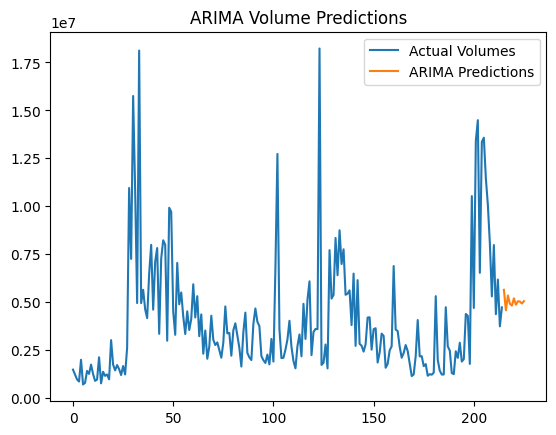

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Copy data
df = data

volumes = df['Volume']

model = ARIMA(volumes, order=(5, 1, 0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(volumes), end=len(volumes) + 10)
# Predicts for the next 10 periods

plt.plot(volumes, label='Actual Volumes')
plt.plot(predictions, label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA Volume Predictions')
plt.show()

# ARFIMA

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import datetime as dt

def fractional_differencing(series, d, threshold=1e-5):
    """
    Apply fractional differencing to a time series.

    :param series: Original time series (1D NumPy array or pandas Series).
    :param d: Fractional differencing parameter (float).
    :param threshold: Minimum weight threshold for truncation.
    :return: Fractionally differenced series (NumPy array).
    """
    T = len(series)
    weights = [1]
    for k in range(1, T):
        weight = -weights[-1] * (d - k + 1) / k
        if abs(weight) < threshold:  # Truncate small weights
            break
        weights.append(weight)
    weights = np.array(weights[::-1])  # Reverse weights

    # Apply convolution for fractional differencing
    diff_series = np.convolve(series, weights, mode='valid')
    return diff_series

# Fetch VIX data from Yahoo Finance
end_time = dt.date.today().strftime("%Y-%m-%d")
df = yf.download('^VIX', start='2009-11-13', end=end_time)
time_series = df['Close'].dropna()  # Drop NaN values if any

# Ensure time_series is a 1D NumPy array
time_series = time_series.values.flatten()

# Check the length of the original time series
print(f"Original series length: {len(time_series)}")

# Apply fractional differencing
d = 0.5  # Fractional differencing parameter
frac_diff_series = fractional_differencing(time_series, d)

# Check the length of the differenced series
print(f"Fractionally differenced series length: {len(frac_diff_series)}")

# Ensure sufficient observations after differencing
if len(frac_diff_series) > 30:  # Minimum threshold for fitting
    # Fit ARIMA to the fractionally differenced series
    model = ARIMA(frac_diff_series, order=(1, 0, 1))  # ARMA model (p, 0, q)
    result = model.fit()

    # Summary of the model
    print(result.summary())

    # Forecast
    forecast = result.forecast(steps=10)
    print("Forecast:", forecast)
else:
    print("Not enough observations after fractional differencing.")


[*********************100%***********************]  1 of 1 completed


Original series length: 3808
Fractionally differenced series length: 2882
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2882
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5876.953
Date:                Fri, 03 Jan 2025   AIC                          11761.905
Time:                        10:29:09   BIC                          11785.770
Sample:                             0   HQIC                         11770.507
                               - 2882                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3490      0.123      2.826      0.005       0.107       0.591
ar.L1          0.8393      0.008    103.257      0.000   

# Bayesian



In [ ]:
import numpy as np

# Copy data
df = data

# Define a class to hold our prior belief
class Prior:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Define a class to hold our likelihood
class Likelihood:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Function to update our prior with new evidence
def bayesian_update(prior, likelihood):
    prior_variance_inv = 1.0 / prior.variance
    likelihood_variance_inv = 1.0 / likelihood.variance

    updated_variance = 1.0 / (prior_variance_inv + likelihood_variance_inv)
    updated_mean = updated_variance * (prior.mean * prior_variance_inv + likelihood.mean * likelihood_variance_inv)

    return Prior(mean=updated_mean, variance=updated_variance)

# Function to calculate mean and variance from records
def calculate_statistics(df, scale_factor=1):
    volumes = df['Volume'].astype(float) / scale_factor  # Scale the volumes
    mean = np.mean(volumes)
    variance = np.var(volumes)
    return mean, variance

# Function to apply Bayesian update using the DataFrame
def bayesian_with_volumes_df(df, scale_factor=1):
    try:
        # Sort DataFrame by index in descending order to get the most recent records at the top
        df = df.sort_index(ascending=False)

        # Calculate statistics for the prior using all records
        prior_mean, prior_variance = calculate_statistics(df, scale_factor)

        # Extract the most recent record as new evidence
        latest_record = df.iloc[0]  # Get the most recent row
        new_evidence_volume = float(latest_record['Volume']) / scale_factor  # Use iloc[0] for scalar value

        # For simplicity, use the prior variance as the variance for the new evidence
        new_evidence_variance = prior_variance

        # Define the prior and likelihood based on these values
        prior = Prior(mean=prior_mean, variance=prior_variance)
        likelihood = Likelihood(mean=new_evidence_volume, variance=new_evidence_variance)

        # Perform Bayesian update
        updated_prior = bayesian_update(prior, likelihood)

        # Ensure the values are float scalars when printing
        print(f"Updated Prior: mean = {updated_prior.mean:.2f}, variance = {updated_prior.variance:.2f}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage with scaling (e.g., volumes in millions)
bayesian_with_volumes_df(df, scale_factor=1_000_000)

def print_legend():
    print("----- Legend for Updated Bayesian Results -----")
    print("Updated Mean: This is the new expected average trading volume after the Bayesian update, adjusted by the scaling factor. A higher mean suggests a higher expected volume of trades.")
    print("Updated Variance: This represents the uncertainty or variability around the updated mean. A lower variance indicates more confidence in the updated average, while a higher variance suggests more fluctuation is possible.")
    print("-----------------------------------------------\n")

# Call the function to print the legend
print_legend()




Updated Prior: mean = 4.38, variance = 4.87
----- Legend for Updated Bayesian Results -----
Updated Mean: This is the new expected average trading volume after the Bayesian update, adjusted by the scaling factor. A higher mean suggests a higher expected volume of trades.
Updated Variance: This represents the uncertainty or variability around the updated mean. A lower variance indicates more confidence in the updated average, while a higher variance suggests more fluctuation is possible.
-----------------------------------------------



# Box-Counting Dimension

https://www.intechopen.com/chapters/64463

Fractal Analysis of Time-Series Data Sets: Methods and Challenges

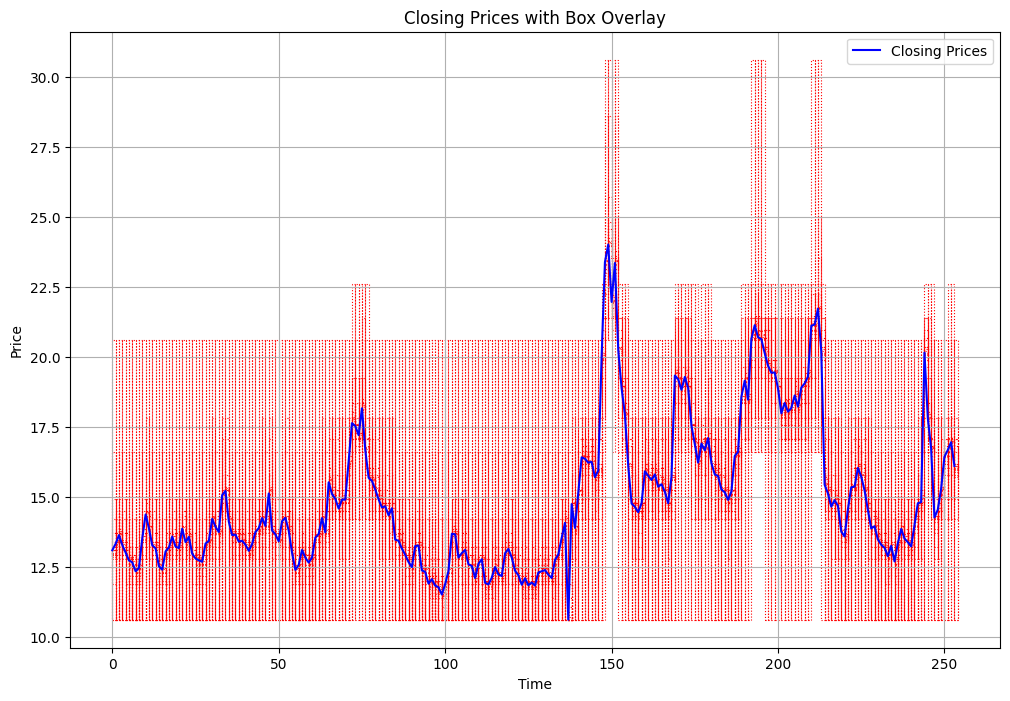

Box-Counting Dimension: 0.8307124508034185


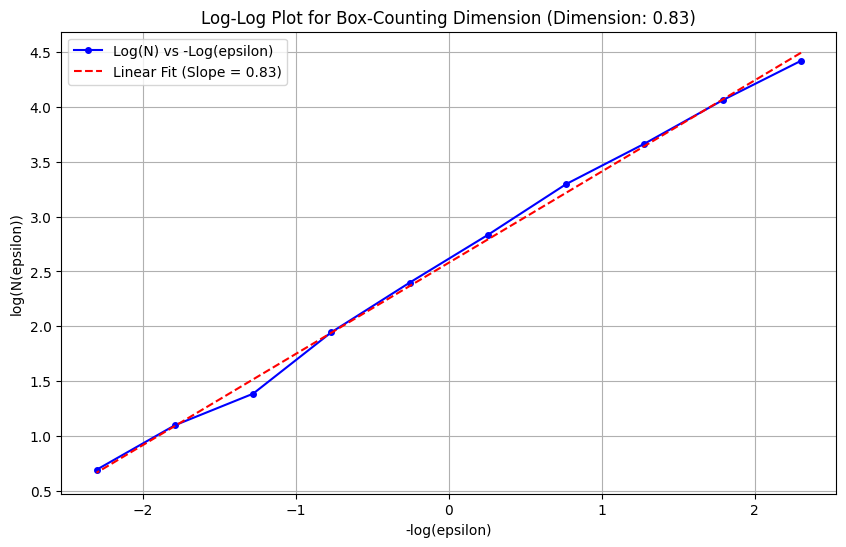

In [17]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def box_counting_dimension_with_visualization(data, epsilons):
    """
    Calculate the box-counting dimension for a given time series and visualize the boxes.
    Parameters:
    - data: The 1D time series data.
    - epsilons: A list of box sizes (scales) to test.
    Returns:
    - The box-counting dimension, and arrays for log(epsilons) and log(N(epsilons)).
    """
    N = []  # Stores the number of boxes required for each epsilon
    min_val = min(data)
    max_val = max(data)

    plt.figure(figsize=(12, 8))
    plt.plot(range(len(data)), data, label="Closing Prices", color="blue")

    for epsilon in epsilons:
        count = 0
        box_edges = []
        active_boxes = []  # Store active boxes that intersect with data

        # Define the grid of boxes by moving across intervals of size epsilon
        for i in range(int((max_val - min_val) / epsilon) + 1):
            lower_bound = min_val + i * epsilon
            upper_bound = min_val + (i + 1) * epsilon

            # Check if there are any data points in the current box interval
            if any((data >= lower_bound) & (data < upper_bound)):
                count += 1
                box_edges.append((lower_bound, upper_bound))
                active_boxes.append((lower_bound, upper_bound))

        # Visualize the active boxes
        for lower_bound, upper_bound in active_boxes:
            for start_idx in range(len(data)):
                if data[start_idx] >= lower_bound and data[start_idx] < upper_bound:
                    rect = patches.Rectangle(
                        (start_idx, lower_bound),  # (x, y) position of the box
                        1,  # width of the box
                        upper_bound - lower_bound,  # height of the box
                        linewidth=0.8,
                        edgecolor="red",
                        facecolor="none",
                        linestyle="dotted"
                    )
                    plt.gca().add_patch(rect)

        N.append(count)

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("Closing Prices with Box Overlay")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Log of N and epsilon for linear regression
    log_eps = -np.log(epsilons)
    log_N = np.log(N)

    # Calculate the slope of the line, which is the fractal dimension
    coeffs = np.polyfit(log_eps, log_N, 1)
    return coeffs[0], log_eps, log_N

# Load a sample time series data for Apple Inc.
df = data

# Use the closing prices for fractal analysis
time_series_data = df['Close'].dropna().values

# Define a range of box sizes (scales) for box-counting
epsilons = np.logspace(-1, 1, num=10)

# Calculate the box-counting dimension and visualize
dimension, log_eps, log_N = box_counting_dimension_with_visualization(time_series_data, epsilons)
print("Box-Counting Dimension:", dimension)

# Plot the log-log plot
plt.figure(figsize=(10, 6))

# Plot the log-log points
plt.plot(log_eps, log_N, 'bo-', markersize=4, label='Log(N) vs -Log(epsilon)')

# Overlay a linear fit line for visualization of the dimension
coeffs = np.polyfit(log_eps, log_N, 1)
plt.plot(log_eps, np.polyval(coeffs, log_eps), 'r--', label=f'Linear Fit (Slope = {coeffs[0]:.2f})')

# Add labels, title, and legend
plt.xlabel('-log(epsilon)')
plt.ylabel('log(N(epsilon))')
plt.title(f'Log-Log Plot for Box-Counting Dimension (Dimension: {dimension:.2f})')
plt.legend(loc='best')  # Automatically place the legend in the best position
plt.grid(True)
plt.show()


In [14]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def box_counting_dimension(data, epsilons):
    """
    Calculate the box-counting dimension for a given time series.
    Parameters:
    - data: The 1D time series data.
    - epsilons: A list of box sizes (scales) to test.
    """
    N = []  # Stores the number of boxes required for each epsilon
    for epsilon in epsilons:
        count = 0
        min_val = min(data)
        max_val = max(data)

        # Define the grid of boxes by moving across intervals of size epsilon
        for i in range(int((max_val - min_val) / epsilon) + 1):
            # Check if there are any data points in the current box interval
            if any((data >= min_val + i * epsilon) & (data < min_val + (i + 1) * epsilon)):
                count += 1
        N.append(count)

    # Convert N and epsilon to logarithmic values for fitting
    log_eps = -np.log(epsilons)
    log_N = np.log(N)

    # Calculate the slope of the line, which is the fractal dimension
    coeffs = np.polyfit(log_eps, log_N, 1)
    return coeffs[0]

df = data

# Use the closing prices for fractal analysis
time_series_data = df['Close'].dropna().values

# Define a range of box sizes (scales) for box-counting
epsilons = np.logspace(-1, 1, num=50)

# Calculate the box-counting dimension
dimension = box_counting_dimension(time_series_data, epsilons)
print("Box-Counting Dimension:", dimension)

# Log-log plot for visual verification
log_eps = -np.log(epsilons)
log_N = np.log([np.sum((time_series_data >= min(time_series_data) + i * epsilon) &
                       (time_series_data < min(time_series_data) + (i + 1) * epsilon))
                for epsilon in epsilons for i in range(int((max(time_series_data) - min(time_series_data)) / epsilon) + 1)])

plt.figure(figsize=(8, 6))
plt.plot(log_eps, log_N[:len(log_eps)], 'bo-', markersize=4, label='Box count')
plt.xlabel('-log(epsilon)')
plt.ylabel('log(N(epsilon))')
plt.title(f'Log-Log Plot for Box-Counting Dimension (Dimension: {dimension:.2f})')
plt.legend()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

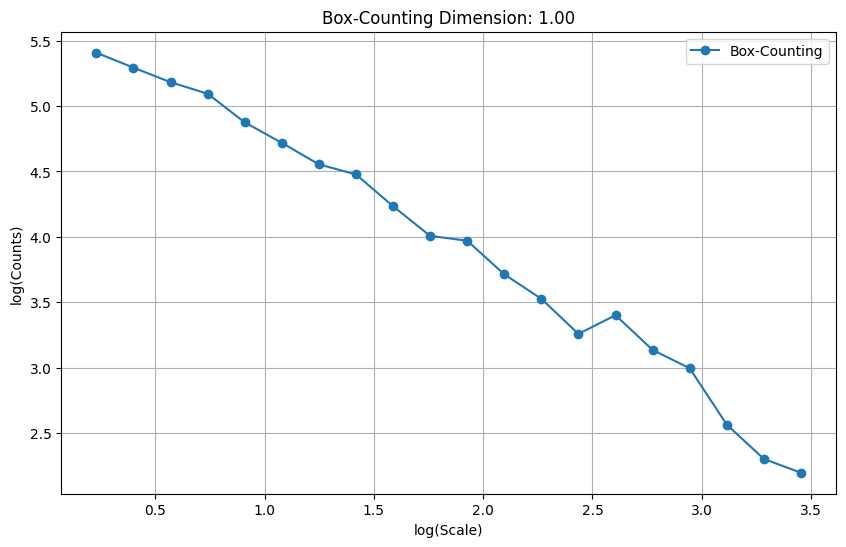

Box-Counting Dimension: 1.00


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def box_counting_dimension(data, scale_sizes):
    counts = []
    for scale in scale_sizes:
        boxes = np.floor(data / scale)
        unique_boxes = np.unique(boxes, axis=0)
        counts.append(len(unique_boxes))
    return counts

df = data

# Ensure vix_prices is a 1D array
vix_prices = df['Close'].values  # Assuming 'Close' is the relevant column

# Generate a time axis with the same length
time_axis = np.arange(len(vix_prices))

# Combine time and VIX prices into a 2D array
data = np.vstack((time_axis, vix_prices)).T

# Define scale sizes (box sizes) to test
scale_sizes = np.logspace(0.1, 1.5, num=20)  # Adjust as needed

# Calculate the box-counting dimension
counts = box_counting_dimension(data, scale_sizes)

# Fit a line to the log-log plot to find the slope (dimension)
coeffs = np.polyfit(np.log(scale_sizes), np.log(counts), 1)
dimension = -coeffs[0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.log(scale_sizes), np.log(counts), 'o-', label='Box-Counting')
plt.xlabel('log(Scale)')
plt.ylabel('log(Counts)')
plt.title(f'Box-Counting Dimension: {dimension:.2f}')
plt.legend()
plt.grid(True)
plt.show()

print(f'Box-Counting Dimension: {dimension:.2f}')


# Chua's Circuit - Chaotic Algorithm

Need to revise

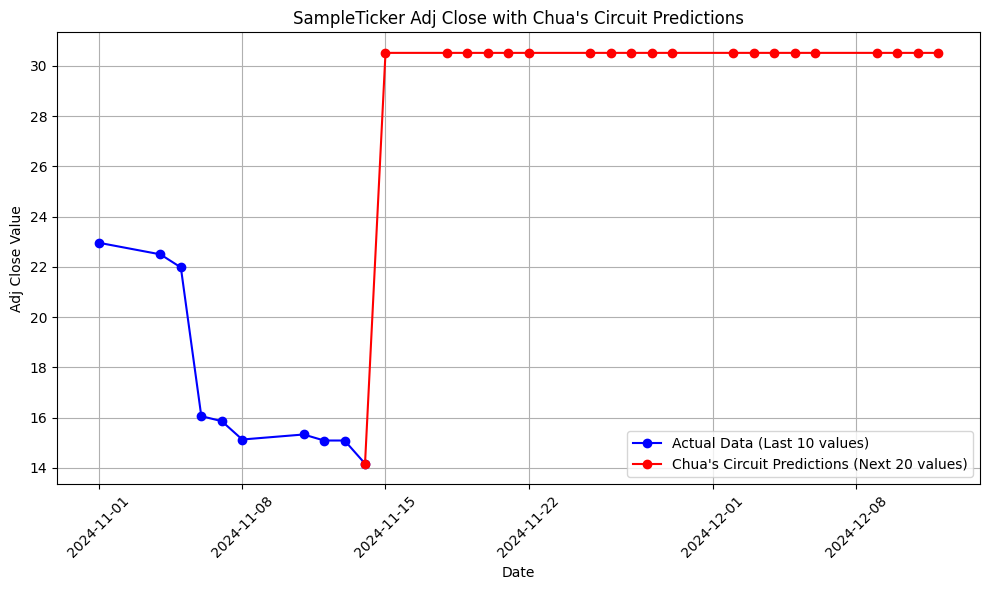

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Chua's circuit parameters
alpha = 15
beta = 28
# Piecewise linear function for Chua's diode
def f(x):
    # Example piecewise linear function
    m1, m2 = -1, 1
    return m1 * x + (m2 - m1) * (x + 1) * (x > -1) * (x < 1)

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with Chua's circuit
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Chua's circuit equations
def chua(t, state):
    x, y, z = state
    dxdt = alpha * (y - x - f(x))
    dydt = x - y + z
    dzdt = -beta * y
    return [dxdt, dydt, dzdt]

# Use solve_ivp to integrate Chua's circuit equations
initial_state = [initial_value, 0.0, 0.0]  # Assuming y and z start at 0
sol = solve_ivp(chua, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Chua's Circuit Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Chua's Circuit Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Duffing Oscillator - Chaotic Algorithm

Need to revise

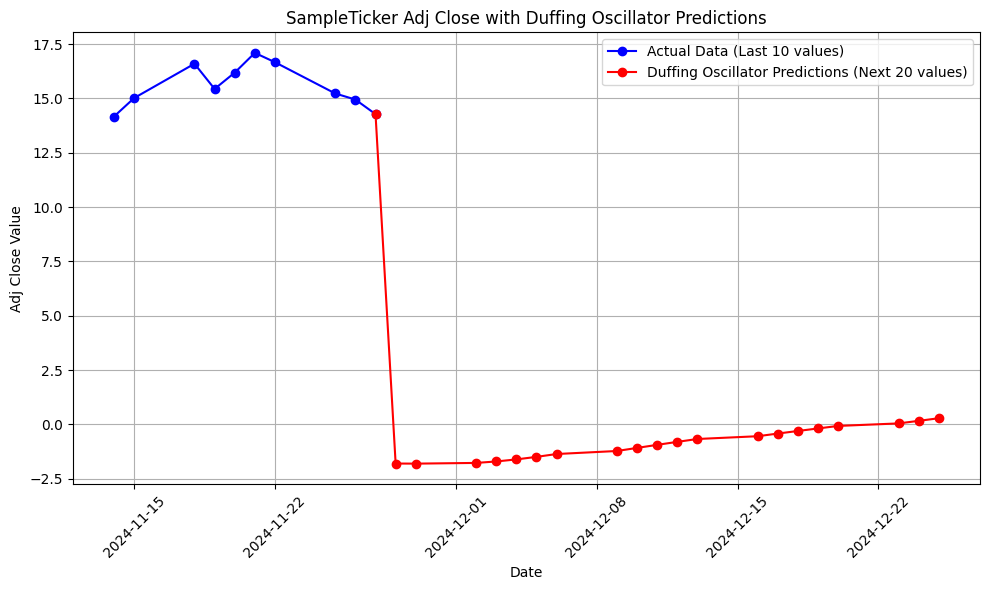

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Duffing oscillator parameters
delta = 0.2    # Damping coefficient
alpha = -1.0   # Linear stiffness
beta = 1.0     # Nonlinear stiffness
gamma = 0.5    # Forcing amplitude
omega = 1.0    # Forcing frequency

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Duffing oscillator
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Duffing oscillator equations
def duffing(t, state):
    x, v = state  # state = [displacement, velocity]
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return [dxdt, dvdt]

# Use solve_ivp to integrate the Duffing oscillator equations
initial_state = [initial_value, 0.0]  # Assuming velocity starts at 0
sol = solve_ivp(duffing, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Duffing Oscillator Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Duffing Oscillator Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Echo State Network

In [ ]:
pip install git+https://github.com/cknd/pyESN #pip install pyEsn #

  Cloning https://github.com/cknd/pyESN to /tmp/pip-req-build-rtachiwy
  Running command git clone --filter=blob:none --quiet https://github.com/cknd/pyESN /tmp/pip-req-build-rtachiwy
  Resolved https://github.com/cknd/pyESN to commit de294b637450abc072d1e0f49fcca7355450482d
ERROR: git+https://github.com/cknd/pyESN does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


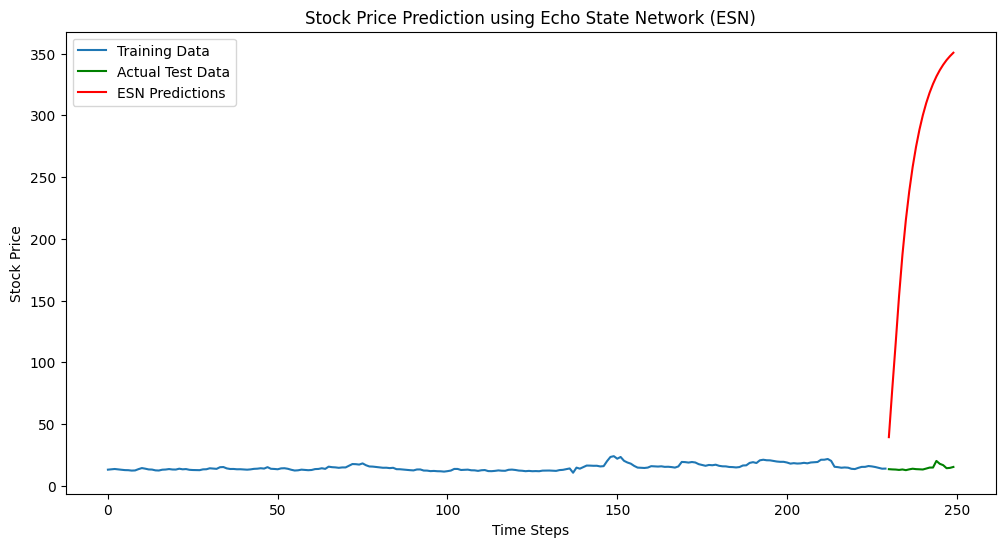

In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
# from pyESN import ESN

import numpy as np


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

df = data

time_series_data = df['Close'].dropna().values

# Normalize the data for better ESN performance
data_mean = np.mean(time_series_data)
data_std = np.std(time_series_data)
normalized_data = (time_series_data - data_mean) / data_std

# Split into train and test sets
train_len = len(normalized_data) - 20  # Leave the last 20 values for testing
train_data = normalized_data[:train_len]
test_data = normalized_data[train_len:]

# Adjusted ESN initialization with different parameters
esn = ESN(
    n_inputs=1,
    n_outputs=1,
    n_reservoir=298,  # Adjust the number of neurons to avoid overfitting
    spectral_radius=1.37,  # Slightly reduce the spectral radius
    sparsity=0.1,  # Increase sparsity to avoid overfitting
    #noise=0.01,  # Introduce noise for regularization
    #teacher_forcing=True,  # Keep teacher forcing to help with training
    random_state=42
)

# Train the ESN on the training data
esn.fit(train_data[:-1].reshape(-1, 1), train_data[1:].reshape(-1, 1))

# Predict the next 20 values
predicted_values = []
last_value = train_data[-1]

for _ in range(20):
    prediction = esn.predict(np.array(last_value).reshape(1, -1))[0][0]
    predicted_values.append(prediction)
    last_value = prediction  # Feed back the last prediction

# Rescale the predictions to the original scale
predicted_values = np.array(predicted_values) * data_std + data_mean
test_data_rescaled = test_data * data_std + data_mean
train_data_rescaled = train_data * data_std + data_mean

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data_rescaled)), train_data_rescaled, label="Training Data")
plt.plot(range(len(train_data_rescaled), len(train_data_rescaled) + len(test_data_rescaled)), test_data_rescaled, label="Actual Test Data", color="green")
plt.plot(range(len(train_data_rescaled), len(train_data_rescaled) + len(predicted_values)), predicted_values, label="ESN Predictions", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction using Echo State Network (ESN)")
plt.show()





# Fractional Gaussian Noise (fGn)

Simulated fGn: [ 1.45108167  0.60801422  0.34869845 -0.29630364 -0.20400379  0.0315656
 -0.40641638  0.88927677  0.09917269  0.4363731  -1.06463164  1.61519319
  0.03845807  0.68300842  0.99225813  1.35301101  0.48170472  1.2671229
  0.59178076  1.83215094 -0.3444742  -2.25624064  0.77553304  0.98560914
  0.22396062  1.26407469 -0.0629715  -0.64246145  0.46752502 -0.03956474
 -0.01789844 -0.25033661  1.4129029  -0.2584493   0.80650843  1.35962335
  0.80501926  0.08344223  0.54593905 -0.77306694  1.18169547  2.06180331
  0.59985399  0.76568671 -0.95602086  0.46787438 -0.86712637  0.15316995
  1.82500941 -0.26412445  0.26733095 -0.41031818 -0.58854281 -0.13541172
  1.27415695  0.25111188 -0.97318732 -0.88652384 -1.78336497 -1.19374855
 -2.52584587 -1.2431114  -1.56488164 -0.2626402  -0.98758165 -0.66543159
 -0.19656508 -0.25037718 -0.49373399 -0.85465752 -0.69077379 -1.05856239
 -0.50242469 -1.84122022 -0.39461349  0.81868037  0.90964159 -1.0180908
  0.61556182 -0.93529599 -0.71088551  0

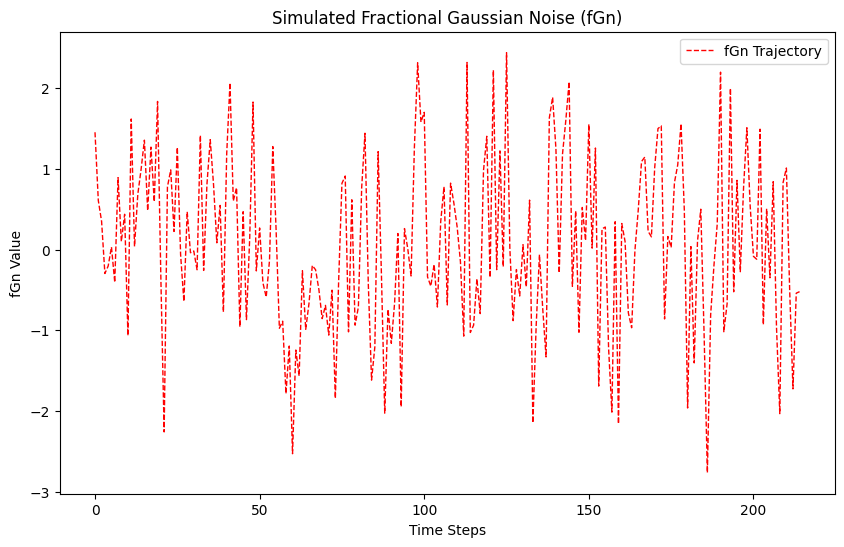

In [ ]:
import numpy as np
from scipy.linalg import cholesky

# Copy data
df = data

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def simulate_fbm(hurst, length):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)
    z = np.random.normal(size=(length,))

    fbm_series = cholesky_decomp.dot(z)
    return fbm_series

def simulate_fgn(hurst, length):
    fbm_series = simulate_fbm(hurst, length + 1)
    fgn_series = np.diff(fbm_series)
    return fgn_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate fGn
fgn_series = simulate_fgn(hurst, len(df['Volume']))
print(f"Simulated fGn: {fgn_series}")

plt.figure(figsize=(10, 6))

# Plot fGn
plt.plot(fgn_series, label='fGn Trajectory', color='r', linestyle='--', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('fGn Value')
plt.title('Simulated Fractional Gaussian Noise (fGn)')
plt.legend()
plt.show()


# Fractional Lévy Stable Motion (FLSM)

Simulated FLSM: [ 6.86239927e-01  1.79127865e+00 -6.41336871e-01 -1.47244710e+00
 -1.79818781e+00 -5.10312930e-02  3.75068528e-01  3.85078403e+00
  5.30358052e+00  4.46241113e+00  5.72833271e+00  6.62492117e+00
  7.13227097e+00  8.58617344e+00  8.87215657e+00  1.01020296e+01
  8.31326131e+00  9.18045133e+00  5.77685016e+00  2.32528680e-01
 -8.69025817e-01 -1.52305212e+00  2.95289770e-01  3.47988912e+00
  5.87159430e+00  7.12480622e+00  5.46680684e+00  3.96853653e+00
  1.24230384e+01  1.44665320e+01  1.60871547e+01  1.72018305e+01
  2.15062007e+01  2.38905546e+01  8.48594255e+01  9.53669022e+01
  9.98161584e+01  1.01599054e+02  1.04572288e+02  1.07612543e+02
  1.10585755e+02  1.14533178e+02  1.11209392e+02  1.11276896e+02
  1.12354854e+02  1.11616117e+02  1.13088717e+02  1.11146869e+02
  1.11861266e+02  1.12536395e+02  1.12459807e+02  1.13230416e+02
 -4.84894345e+02 -5.88777554e+02 -6.34477291e+02 -6.63238991e+02
 -6.86986103e+02 -7.07785839e+02 -7.20700637e+02 -7.33320841e+02
 -7.47213

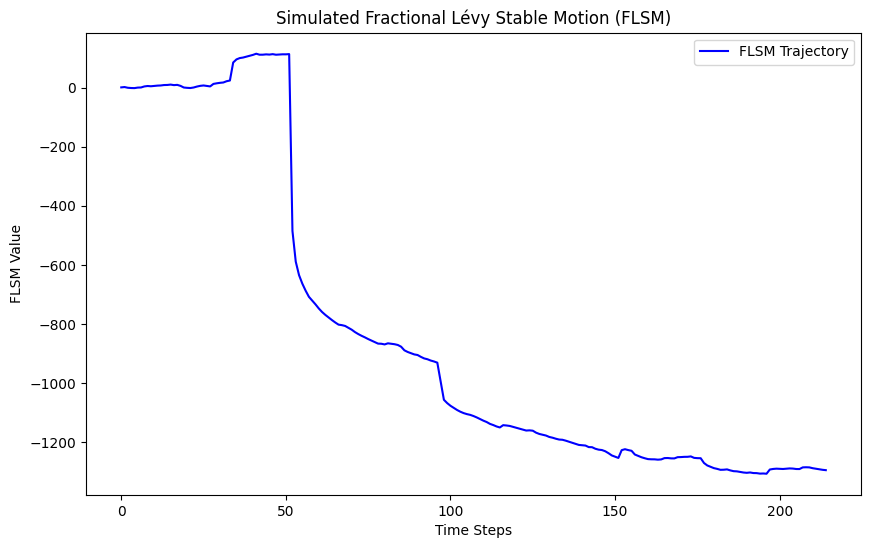

In [ ]:
import numpy as np
from scipy.linalg import cholesky

# Copy data
df = data

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def levy_stable(alpha, beta, sigma, mu):
    u = np.random.uniform(-np.pi/2, np.pi/2)
    w = np.random.normal()

    if alpha == 1.0:
        return mu + beta * np.tan(np.pi / 2 + beta * u) * sigma * np.log(np.pi / 2 + beta * u)

    zeta = beta * np.tan(np.pi / 2 * alpha)
    term1 = (1 + zeta ** 2) ** 0.5
    term2 = np.tan(alpha * u)
    term3 = np.log(1 + zeta * term2)
    term4 = (1 / alpha) * (term1 * term2 - zeta * (w - term3))

    return mu + sigma * term4

def simulate_flm(hurst, length, alpha):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)

    z = [levy_stable(alpha, 0.0, 1.0, 0.0) for _ in range(length)]
    z_matrix = np.array(z)

    flm_series = cholesky_decomp.dot(z_matrix)
    return flm_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate FLSM
flm_series = simulate_flm(hurst, len(df['Volume']), alpha=1.5)
print(f"Simulated FLSM: {flm_series}")

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(flm_series, label='FLSM Trajectory', color='b')

# Add labels and title
plt.xlabel('Time Steps')
plt.ylabel('FLSM Value')
plt.title('Simulated Fractional Lévy Stable Motion (FLSM)')
plt.legend()

# Display the plot
plt.show()

# Fuzzy Logic

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.5 MB/s eta 0:00:00


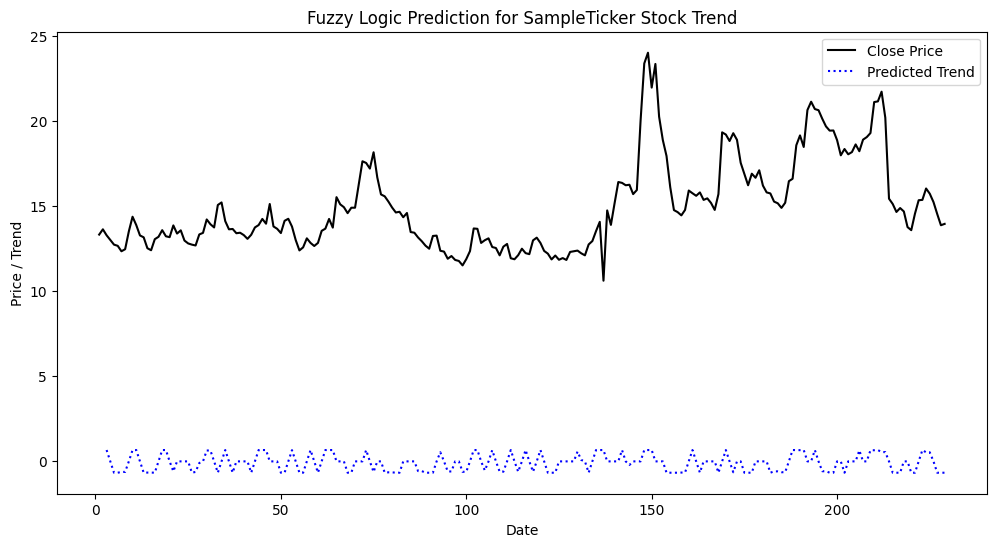

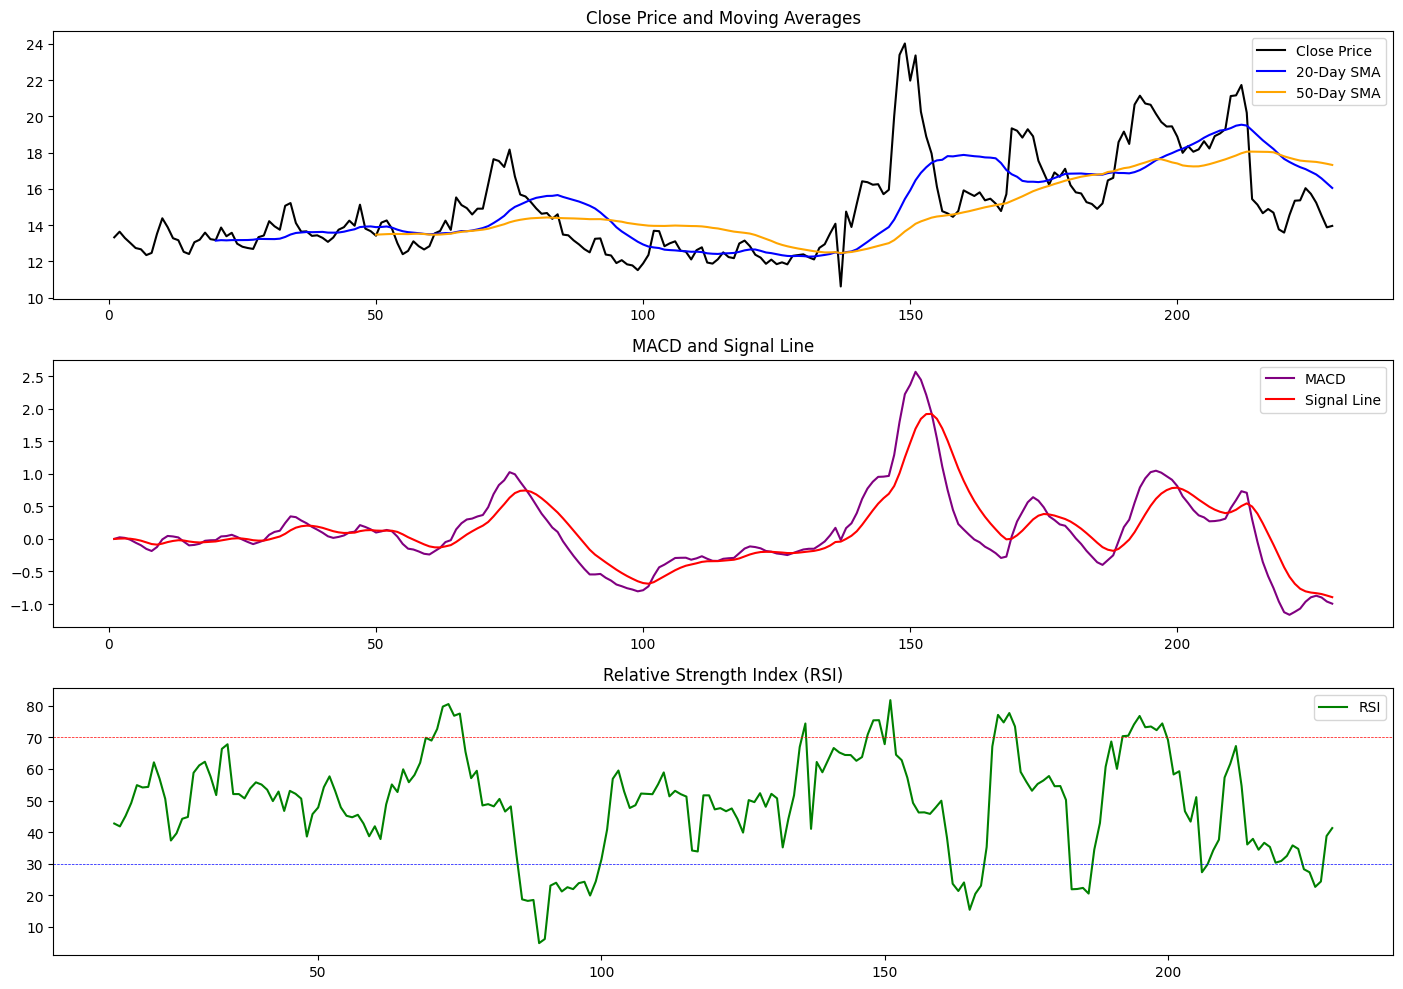

In [ ]:
import yfinance as yf
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt

# Copy data
df = data

df = df[['Date', 'Close']]
df = df.dropna()

# Calculate daily price change percentages
df['Change'] = df['Close'].pct_change() * 100
df = df.dropna()

# Fuzzy variables for the last two days' price changes
change_day1 = ctrl.Antecedent(np.arange(-5, 5, 0.1), 'change_day1')
change_day2 = ctrl.Antecedent(np.arange(-5, 5, 0.1), 'change_day2')
trend = ctrl.Consequent(np.arange(-1, 2, 1), 'trend')

# Define fuzzy membership functions for the inputs
change_day1['decrease'] = fuzz.trapmf(change_day1.universe, [-5, -5, -1, 0])
change_day1['stable'] = fuzz.trimf(change_day1.universe, [-1, 0, 1])
change_day1['increase'] = fuzz.trapmf(change_day1.universe, [0, 1, 5, 5])

change_day2['decrease'] = fuzz.trapmf(change_day2.universe, [-5, -5, -1, 0])
change_day2['stable'] = fuzz.trimf(change_day2.universe, [-1, 0, 1])
change_day2['increase'] = fuzz.trapmf(change_day2.universe, [0, 1, 5, 5])

# Define fuzzy membership functions for the output
trend['decrease'] = fuzz.trimf(trend.universe, [-1, -1, 0])
trend['stable'] = fuzz.trimf(trend.universe, [-1, 0, 1])
trend['increase'] = fuzz.trimf(trend.universe, [0, 1, 1])

rule1 = ctrl.Rule(change_day1['decrease'] & change_day2['decrease'], trend['decrease'])
rule2 = ctrl.Rule(change_day1['stable'] & change_day2['stable'], trend['stable'])
rule3 = ctrl.Rule(change_day1['increase'] & change_day2['increase'], trend['increase'])
rule4 = ctrl.Rule(change_day1['decrease'] & change_day2['increase'], trend['stable'])
rule5 = ctrl.Rule(change_day1['increase'] & change_day2['decrease'], trend['stable'])

# Create the control system and simulation
trend_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
trend_sim = ctrl.ControlSystemSimulation(trend_ctrl)

# Predict trends for the last few days
predictions = []
for i in range(2, len(df)):
    trend_sim.input['change_day1'] = df['Change'].iloc[i-1]
    trend_sim.input['change_day2'] = df['Change'].iloc[i-2]
    trend_sim.compute()
    predictions.append(trend_sim.output['trend'])

# Add predictions to the DataFrame
df['Predicted_Trend'] = [np.nan, np.nan] + predictions  # Align with input data

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Close Price", color="black")
plt.plot(df['Predicted_Trend'], label="Predicted Trend", color="blue", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Price / Trend")
plt.title(f"Fuzzy Logic Prediction for {ticker} Stock Trend")
plt.legend()
plt.show()

# Assuming `df` is your DataFrame with a 'Close' column
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# RSI Calculation
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Plotting
plt.figure(figsize=(14, 10))

# Plot Close Price with Moving Averages
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='black')
plt.plot(df['SMA_20'], label='20-Day SMA', color='blue')
plt.plot(df['SMA_50'], label='50-Day SMA', color='orange')
plt.title("Close Price and Moving Averages")
plt.legend()

# Plot MACD
plt.subplot(3, 1, 2)
plt.plot(df['MACD'], label='MACD', color='purple')
plt.plot(df['Signal_Line'], label='Signal Line', color='red')
plt.title("MACD and Signal Line")
plt.legend()

# Plot RSI
plt.subplot(3, 1, 3)
plt.plot(df['RSI'], label='RSI', color='green')
plt.axhline(70, color='red', linestyle='--', lw=0.5)
plt.axhline(30, color='blue', linestyle='--', lw=0.5)
plt.title("Relative Strength Index (RSI)")
plt.legend()

plt.tight_layout()
plt.show()

# Heatmap

In [ ]:
!pip install matplotlib numpy

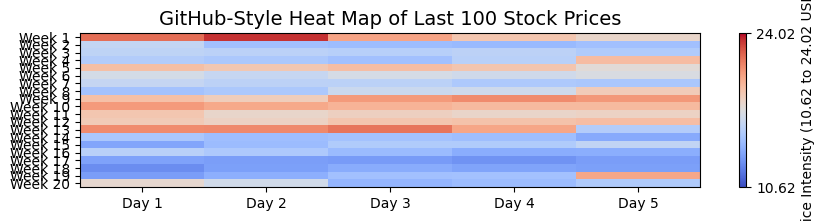

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copy data
df = data

# Load the data (replace with your actual DataFrame or CSV file path)

# Extract the last 100 'Close' prices
last_100_close_prices = df['Close'].tail(100).tolist()

# Normalize the prices for the heatmap
min_val, max_val = df['Close'].min(), df['Close'].max()
normalized_prices = [(price - min_val) / (max_val - min_val) for price in last_100_close_prices]

# Reshape the data into a 20x5 grid
price_grid = np.array(normalized_prices).reshape(20, 5)

# Create the heatmap
plt.figure(figsize=(10, 2))
plt.imshow(price_grid, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)

# Add colorbar with the original price scale
cbar = plt.colorbar(label=f'Price Intensity ({min_val:.2f} to {max_val:.2f} USD)')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f'{min_val:.2f}', f'{max_val:.2f}'])

# Set labels
plt.title('GitHub-Style Heat Map of Last 100 Stock Prices', fontsize=14)
plt.xticks(range(5), labels=[f'Day {i+1}' for i in range(5)])
plt.yticks(range(20), labels=[f'Week {i+1}' for i in range(20)])

# Show the heatmap
plt.show()


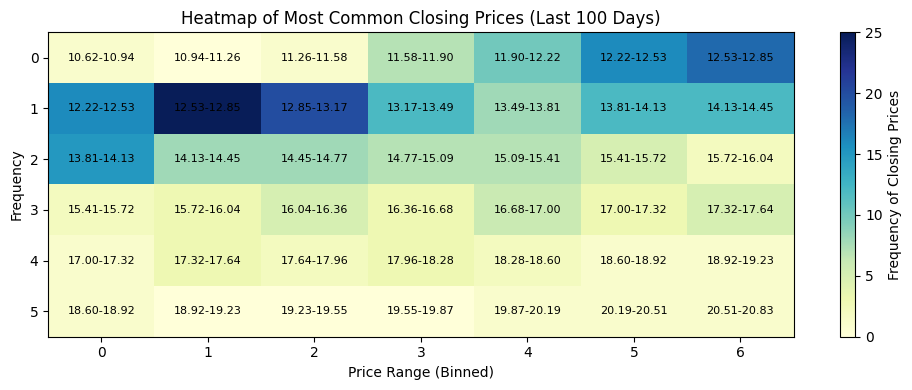

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copy data
df = data

# Extract the last 100 'Close' prices
last_100_close_prices = df['Close'].tail(300).values

# Define the number of bins (adjust as needed)
num_bins = 42

# Create histogram (frequency counts) for the closing prices
counts, bin_edges = np.histogram(last_100_close_prices, bins=num_bins)

# Reshape the frequency counts into a 2D grid for display in a heatmap
# Here, we'll use a 4x5 grid to display the 20 bins
heatmap_data = counts.reshape(6, 7)

# Create the heatmap
plt.figure(figsize=(10, 4))
plt.imshow(heatmap_data, cmap='YlGnBu', aspect='auto')

# Add colorbar to show frequency scale
cbar = plt.colorbar(label='Frequency of Closing Prices')

# Set labels and title
plt.title('Heatmap of Most Common Closing Prices (Last 100 Days)')
plt.xlabel('Price Range (Binned)')
plt.ylabel('Frequency')

# Optionally overlay bin ranges as text on each cell
for i in range(6):
    for j in range(7):
        bin_label = f"{bin_edges[i*5 + j]:.2f}-{bin_edges[i*5 + j + 1]:.2f}"
        plt.text(j, i, bin_label, ha='center', va='center', color='black', fontsize=8)

# Show the heatmap
plt.tight_layout()
plt.show()


# Hénon map - Chaotic Algorithm

Need to revise

Overflow detected; resetting values.


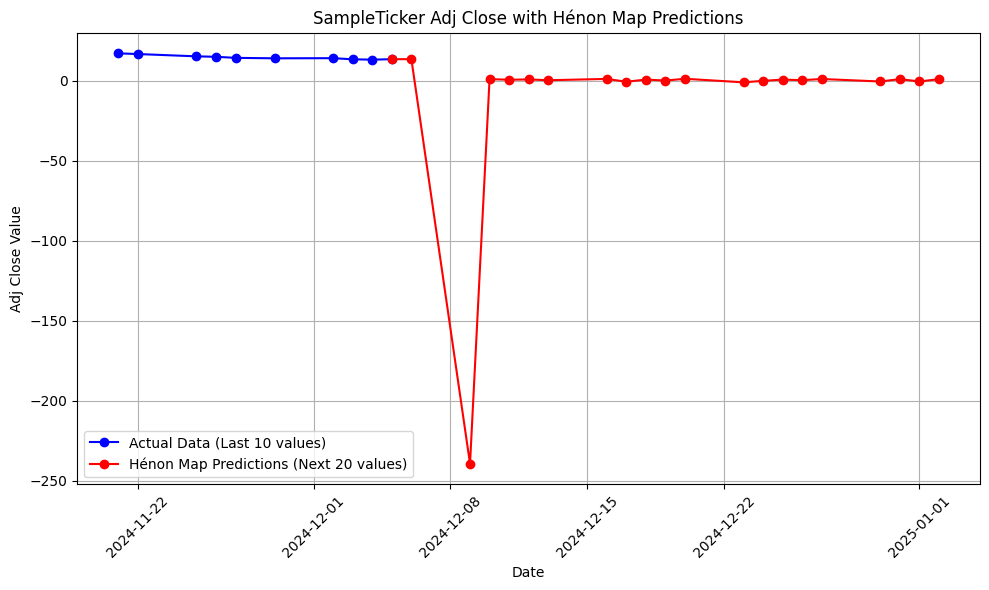

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data
ticker = "SampleTicker"  # Define the ticker symbol

# Hénon map parameters
a = 1.4
b = 0.3
value_limit = 1e3  # Cap values to prevent overflow

# Check if df has at least 10 entries for the starting points
if len(df) >= 10 and df['Adj Close'].notna().sum() >= 10:
    # Extract the last 10 `Adj Close` values
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Hénon map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Hénon map
for _ in range(num_predictions - 1):
    # Calculate the next values
    x_next = 1 - a * x**2 + y
    y_next = b * x

    # Apply limit to prevent overflow
    if abs(x_next) > value_limit or abs(y_next) > value_limit:
        print("Overflow detected; resetting values.")
        x_next, y_next = 1.0, 1.0  # Reset to avoid runaway values

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Hénon Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Hénon Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Higuchi Fractal Dimension

In [ ]:
import numpy as np

# Copy data
df = data

def higuchi_fractal_dimension(time_series, kmax):
    n = len(time_series)
    lengths = np.zeros(kmax)

    for k in range(1, kmax + 1):
        lk = 0.0
        for m in range(k):
            lmk = 0.0
            for i in range(m, n - k, k):
                lmk += abs(time_series[i + k] - time_series[i])
            lmk /= (n - m) / k
            lk += lmk
        lengths[k - 1] = lk / k

    log_lk = np.log10(lengths)
    log_k = np.log10(np.arange(1, kmax + 1))

    # Linear regression to calculate the slope
    slope = np.polyfit(log_k, log_lk, 1)[0]

    return slope

# Normalize the volumes
max_volume = max(df['Volume'])
normalized_volumes = [v / max_volume for v in df['Volume']]

# Calculate Higuchi Fractal Dimension
fractal_dimension = higuchi_fractal_dimension(normalized_volumes, 10) # Need to think about kmax
print(f"Higuchi Fractal Dimension: {fractal_dimension}")
print('\nInterpretation of the Higuchi Fractal Dimension:')
print('1.0 ≤ HFD < 2.0: Indicates smoother or rougher data.')
print('HFD ≈ 1.5: Often observed in fractional Brownian motion.')
print('HFD > 2.0 or < 1.0: Unusual values.\n')

ZeroDivisionError: division by zero

# Hurst Exponent

In [ ]:
import numpy as np

# Copy data
df = data

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))
print(f"Hurst Exponent: {hurst}")
# Print interpretation legend
print("\nInterpretation of the Hurst Exponent:")
print("H < 0.5: Suggests mean-reverting behavior.")
print("H = 0.5: Suggests a random walk.")
print("H > 0.5: Suggests trending behavior.\n")

Hurst Exponent: nan

Interpretation of the Hurst Exponent:
H < 0.5: Suggests mean-reverting behavior.
H = 0.5: Suggests a random walk.
H > 0.5: Suggests trending behavior.



<ipython-input-27-ec6788952f73>:14: RuntimeWarning: invalid value encountered in scalar divide
  hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)


# Ikeda Map - Chaotic Algorithm

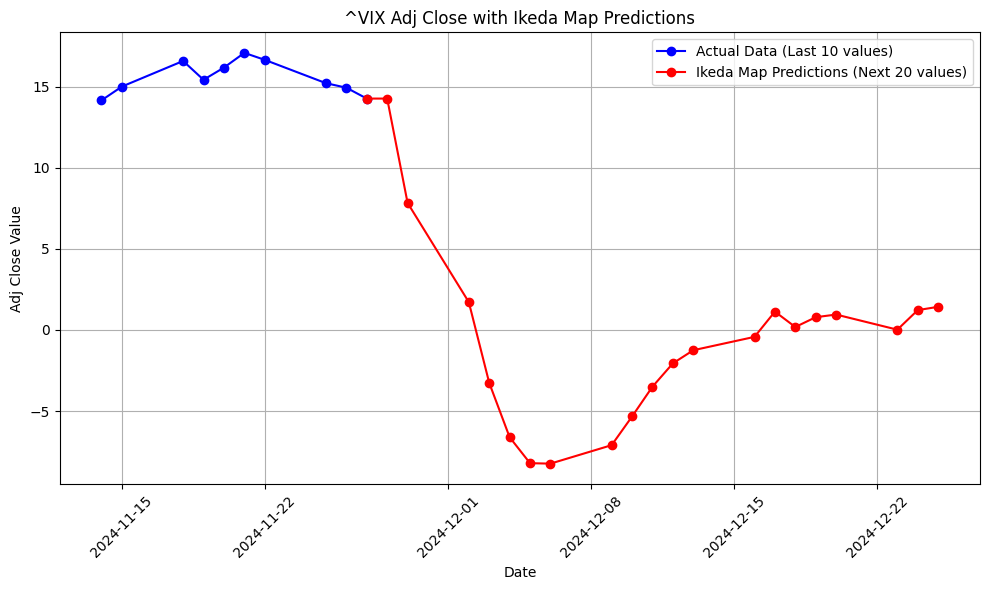

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data

# Parameters for the Ikeda map
u = 0.9
kappa = 0.4
p = 6.0

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Ikeda map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Ikeda map
for _ in range(num_predictions - 1):
    theta = kappa - (p / (1 + x**2 + y**2))
    x_next = 1 + u * (x * np.cos(theta) - y * np.sin(theta))
    y_next = u * (x * np.sin(theta) + y * np.cos(theta))

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Ikeda Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Ikeda Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Julia Sets - Chaotic Algorithm

Need to revise

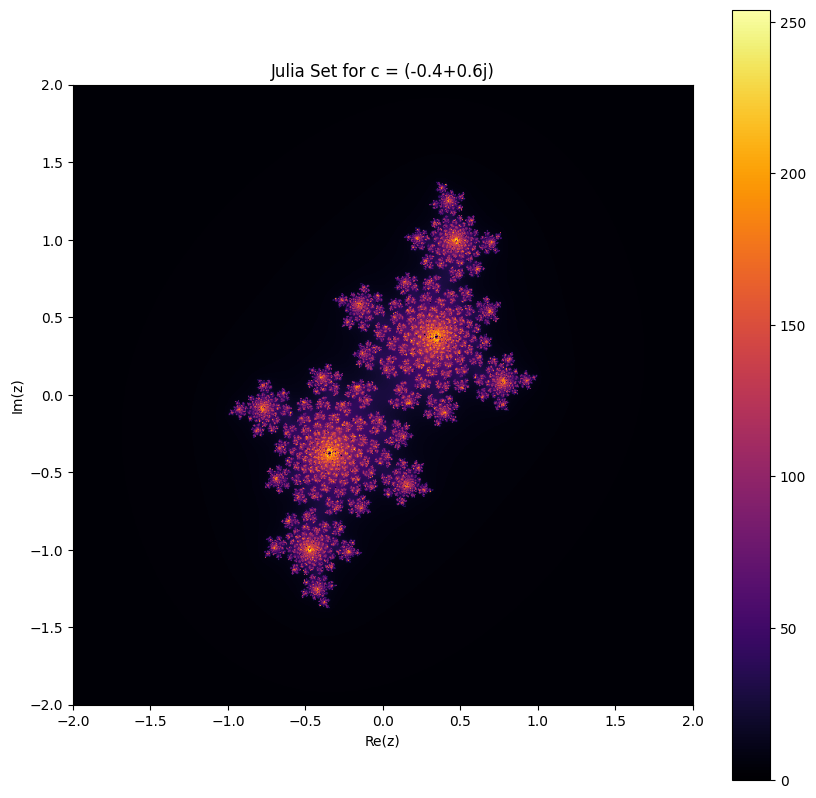

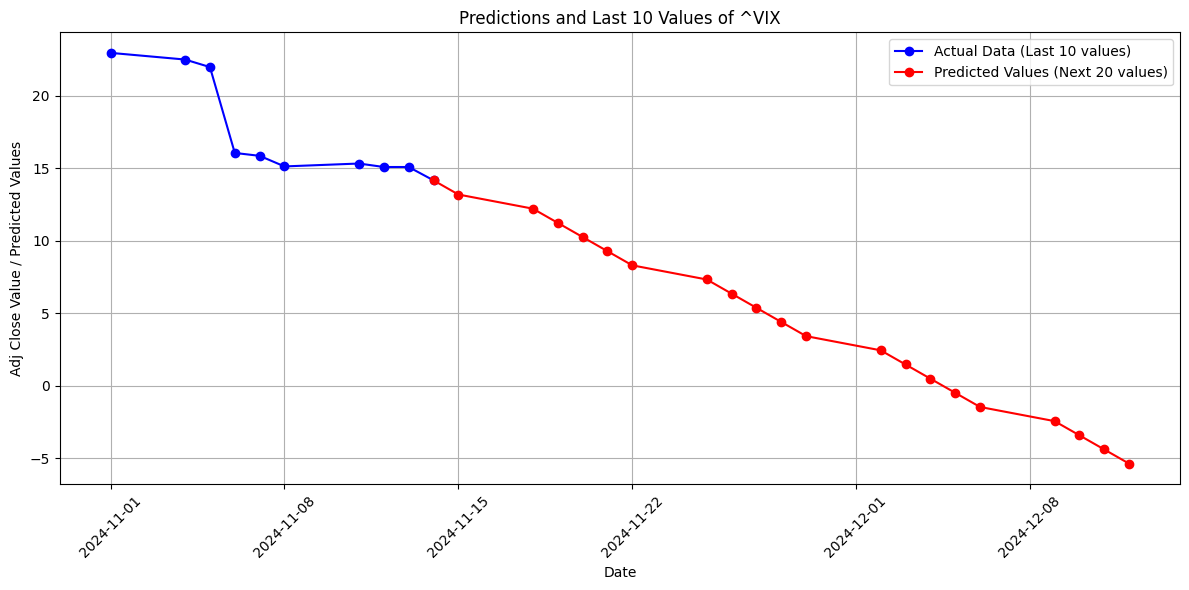

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Copy data
df = data

# Define the function to compute the Julia set
def julia_set(c, xlim, ylim, width, height, max_iter):
    # Create a grid of complex numbers
    x = np.linspace(xlim[0], xlim[1], width)
    y = np.linspace(ylim[0], ylim[1], height)
    z = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    z = z[:, 0] + 1j * z[:, 1]  # Create complex grid

    # Initialize array to hold the iteration counts
    img = np.zeros(z.shape, dtype=int)

    # Iterate over each point in the complex plane
    for i in range(max_iter):
        mask = np.abs(z) < 100  # Only iterate if z is within a certain bound
        img[mask] = i  # Assign the iteration count
        z[mask] = z[mask] ** 2 + c  # Update z

    img[img == max_iter - 1] = 0  # Mark points that never escaped

    # Reshape the result back to the image dimensions
    img = img.reshape((height, width))
    return img

# Parameters for the Julia set
c = complex(-0.4, 0.6)  # The complex parameter
xlim = (-2, 2)          # X-axis limits
ylim = (-2, 2)          # Y-axis limits
width, height = 800, 800  # Image size
max_iter = 256          # Maximum number of iterations

# Generate the Julia set
julia_image = julia_set(c, xlim, ylim, width, height, max_iter)

# Plotting the Julia set
plt.figure(figsize=(10, 10))
plt.imshow(julia_image, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='inferno')
plt.colorbar()
plt.title(f"Julia Set for c = {c}")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(False)
plt.show()

# Chart

# Define the function to compute the Julia set
def julia_set2(c, xlim, ylim, width, height, max_iter):
    # Create a grid of complex numbers
    x = np.linspace(xlim[0], xlim[1], width)
    y = np.linspace(ylim[0], ylim[1], height)
    z = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    z = z[:, 0] + 1j * z[:, 1]  # Create complex grid

    # Initialize array to hold the iteration counts
    img = np.zeros(z.shape, dtype=int)

    # Iterate over each point in the complex plane
    for i in range(max_iter):
        mask = np.abs(z) < 100  # Only iterate if z is within a certain bound
        img[mask] = i  # Assign the iteration count
        z[mask] = z[mask] ** 2 + c  # Update z

    img[img == max_iter - 1] = 0  # Mark points that never escaped

    # Reshape the result back to the image dimensions
    img = img.reshape((height, width))
    return img

# Parameters for the Julia set
c = complex(-0.4, 0.6)  # The complex parameter
xlim = (-2, 2)          # X-axis limits
ylim = (-2, 2)          # Y-axis limits
width, height = 800, 800  # Image size
max_iter = 256          # Maximum number of iterations

# Generate the Julia set
julia_image = julia_set2(c, xlim, ylim, width, height, max_iter)

# Extract real values for time series predictions
real_values = np.linspace(xlim[0], xlim[1], width)[:max_iter]  # Use only a subset for simplicity

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data

# Number of new values to predict with the Julia set real values
num_predictions = 20

# Generate predictions based on a trend from last 10 values
# Calculate the mean and the trend (slope)
last_value = last_10_values[-1]
predicted_values = []

# Simple linear prediction based on last value
slope = (last_10_values[-1] - last_10_values[0]) / 9  # Slope of the line connecting first and last
for i in range(num_predictions):
    next_value = last_value + slope  # Predict next value based on slope
    predicted_values.append(next_value)
    last_value = next_value  # Update last value for next iteration

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(12, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Predicted Values (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value / Predicted Values")
plt.title(f"Predictions and Last 10 Values of {ticker}")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Kalman Filter - Linear Quadratic Estimation

https://en.wikipedia.org/wiki/Kalman_filter

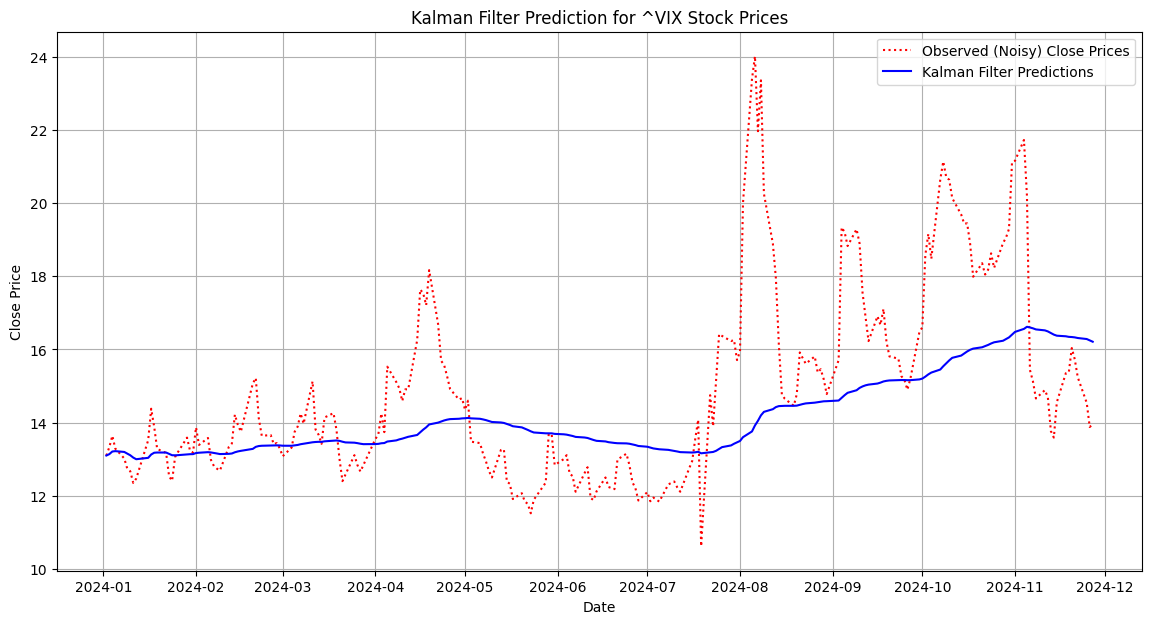

In [ ]:
# Copy data
df = data

df = df[['Date', 'Close']]
df = df.dropna()

# Kalman Filter parameters
observed_values = df['Close'].values  # Observed prices (time series)
predictions = []  # To store predictions
x = observed_values[0]  # Initial state estimate
P = 1  # Initial uncertainty

Q = 1e-3  # Process variance
R = 4     # Measurement variance

# Kalman Filter process
for z in observed_values:
    # Prediction step
    x = x  # No control input, so just state estimate
    P = P + Q  # Update uncertainty in the prediction

    # Update step
    K = P / (P + R)  # Kalman Gain
    x = x + K * (z - x)  # Update estimate with measurement
    P = (1 - K) * P  # Update uncertainty

    # Store prediction
    predictions.append(x)

# Add predictions to DataFrame
df['Kalman_Prediction'] = predictions

# Plot observed and predicted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label="Observed (Noisy) Close Prices", color="red", linestyle="dotted")
plt.plot(df['Date'], df['Kalman_Prediction'], label="Kalman Filter Predictions", color="blue")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"Kalman Filter Prediction for {ticker} Stock Prices")
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression

Need to revise

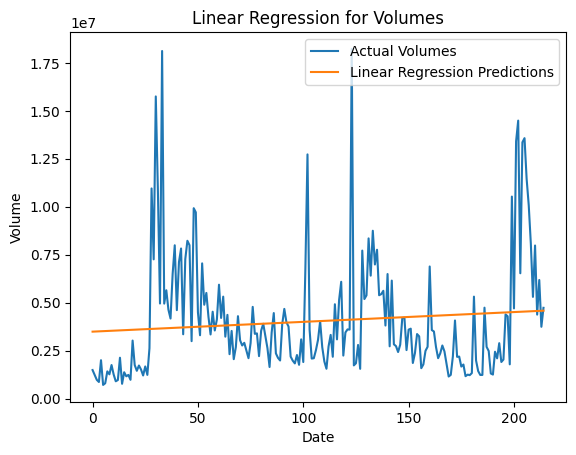

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Copy data
df = data

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'
X = np.arange(len(df)).reshape(-1, 1)  # Create a feature matrix with time steps
y = df['Volume']  # Target variable (volume)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Plot the results
plt.plot(df.index, y, label='Actual Volumes')  # Assuming 'df' has a datetime index
plt.plot(df.index, predictions, label='Linear Regression Predictions')
plt.legend()
plt.title('Linear Regression for Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Lorenz System - Chaotic Algorithm

Need to revise

Lorenz trajectory: [[20.24338608  1.54979773  1.06763776]
 [20.0564502   2.09345014  1.09616388]
 [19.8768202   2.63095214  1.13522796]
 [19.70436152  3.16230743  1.18449565]
 [19.53894098  3.68752752  1.24364824]]


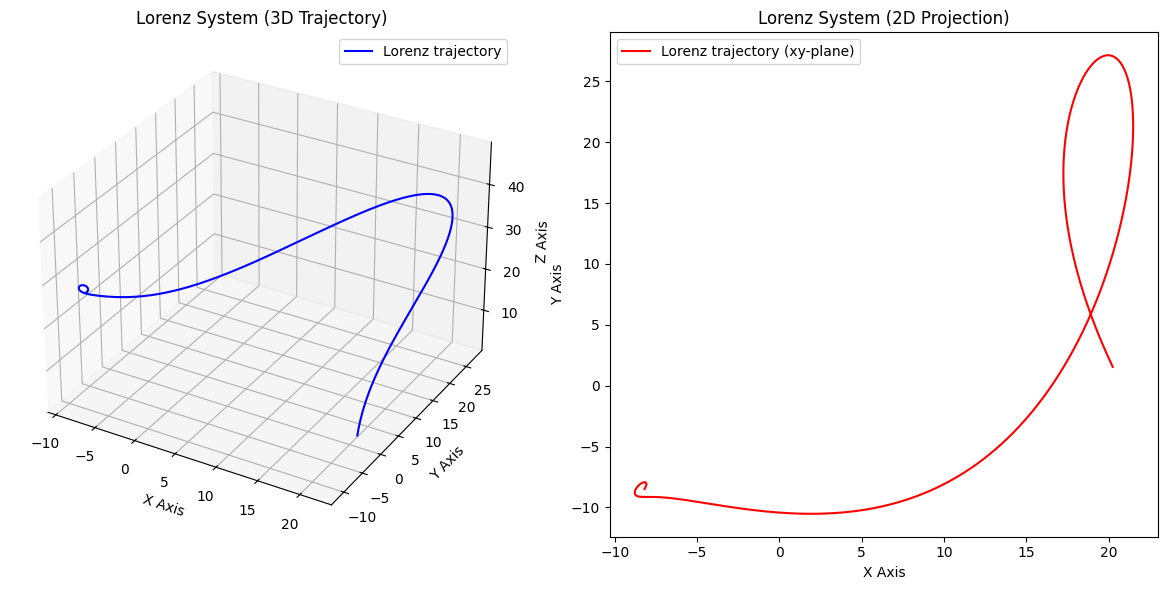

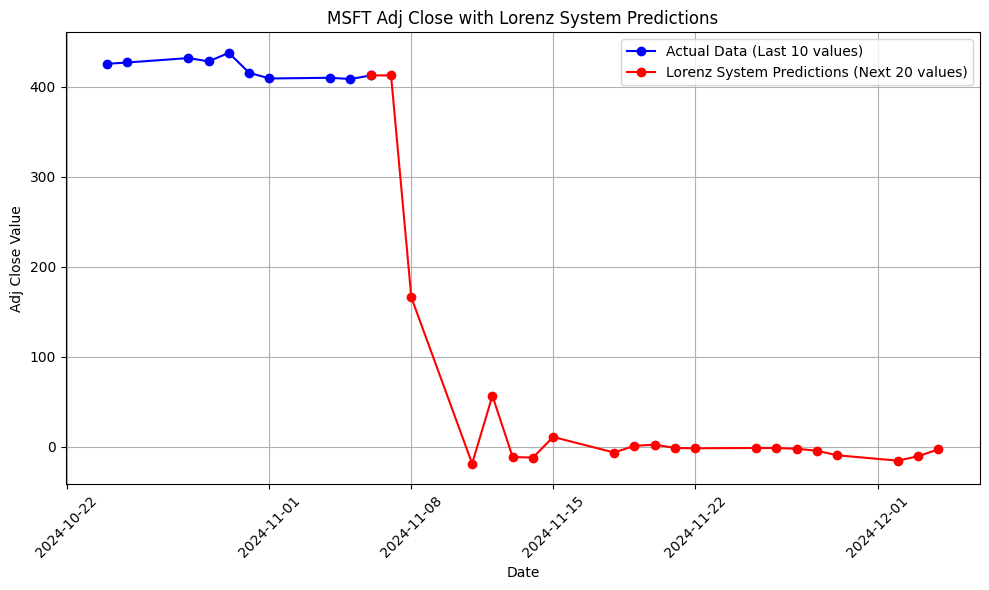

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.integrate import odeint

# Copy data
df = data

def lorenz_system(initial_state, dt, steps):
    sigma = 10.0
    rho = 28.0
    beta = 8.0 / 3.0

    state = np.array(initial_state)
    trajectory = np.zeros((steps, 3))

    for i in range(steps):
        dx = sigma * (state[1] - state[0])
        dy = state[0] * (rho - state[2]) - state[1]
        dz = state[0] * state[1] - beta * state[2]

        state[0] += dx * dt
        state[1] += dy * dt
        state[2] += dz * dt

        trajectory[i] = state

    return trajectory

# Simulate Lorenz system
initial_state = [np.mean(df['Volume']) / 1_000_000, 1.0, 1.05]
lorenz_trajectory = lorenz_system(initial_state, dt=0.001, steps=1000)
print(f"Lorenz trajectory: {lorenz_trajectory[:5]}")  # Show first 5 points

# Extract x, y, z coordinates
x = lorenz_trajectory[:, 0]
y = lorenz_trajectory[:, 1]
z = lorenz_trajectory[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# 3D plot of Lorenz trajectory
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot(x, y, z, label='Lorenz trajectory', color='b')
ax_3d.set_xlabel('X Axis')
ax_3d.set_ylabel('Y Axis')
ax_3d.set_zlabel('Z Axis')
ax_3d.set_title('Lorenz System (3D Trajectory)')
ax_3d.legend()

# 2D plot of the same Lorenz trajectory projected onto the xy-plane
ax_2d = fig.add_subplot(122)
ax_2d.plot(x, y, label='Lorenz trajectory (xy-plane)', color='r')
ax_2d.set_xlabel('X Axis')
ax_2d.set_ylabel('Y Axis')
ax_2d.set_title('Lorenz System (2D Projection)')
ax_2d.legend()

# Show both plots
plt.tight_layout()
plt.show()

# 3rd chart

# Lorenz system parameters
sigma = 10
rho = 28
beta = 8 / 3

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x0, y0 = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x0, y0 = last_10_values[-1], last_10_values[-2]

# Set initial conditions and time points for prediction
z0 = 0.0  # Initial value for z
initial_conditions = [x0, y0, z0]
num_predictions = 20
time = np.linspace(0, 2, num_predictions)  # Time range for predictions

# Define the Lorenz system equations
def lorenz_system2(state, t):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Integrate the Lorenz system
predicted_values = odeint(lorenz_system2, initial_conditions, time)

# Extract predicted x values for the time series
predicted_x_values = predicted_values[:, 0]  # We use x as the predicted series

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_x_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Lorenz System Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Lorenz System Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Markov

**Markov Chain for Price**

In [25]:
import pandas as pd
import numpy as np

# Copy data
df = data

def markov_chain_transition_state(data):
    """
    Generates the Markov Chain transition state matrix.

    Args:
        data: pandas DataFrame containing the price data.

    Returns:
        pandas DataFrame representing the transition state matrix and the predicted next state.
    """

    # Assuming 'Close' column contains the price data
    prices = data['Close'].values

    # Discretize prices into states (e.g., Low, Medium, High)
    low_threshold = data['Close'].quantile(0.33)
    high_threshold = data['Close'].quantile(0.66)
    states = np.where(prices < low_threshold, 'Low', np.where(prices > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (the state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state, predicted_next_state = markov_chain_transition_state(df)
print(transition_state)
print(f"Next predicted state: {predicted_next_state}")

Current state: High
  From/To      High       Low    Medium
0    High  0.906977  0.000000  0.093023
1     Low  0.000000  0.857143  0.142857
2  Medium  0.108434  0.132530  0.759036
Next predicted state: High


**Markov Chain for Volumes**

In [ ]:
import pandas as pd
import numpy as np

# Copy data
df = data

def markov_chain_transition_state_volume(data):
    """
    Generates the Markov Chain transition state matrix and predicts the next state for Volumes.

    Args:
        data: pandas DataFrame containing the volume data.

    Returns:
        tuple: (pandas DataFrame representing the transition state matrix,
                 predicted next state)
    """

    # Convert 'Volume' column to numeric
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Assuming 'Volume' column contains the volume data
    volumes = data['Volume'].values

    # Discretize volumes into states (e.g., Low, Medium, High)
    low_threshold = data['Volume'].quantile(0.33)
    high_threshold = data['Volume'].quantile(0.66)
    states = np.where(volumes < low_threshold, 'Low', np.where(volumes > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state_volume, predicted_next_state_volume = markov_chain_transition_state_volume(df)
print(transition_state_volume)
print(f"Next predicted state for Volume: {predicted_next_state_volume}")

Current state: Medium
  From/To  Medium
0  Medium     1.0
Next predicted state for Volume: Medium


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Copy data
df = data

def predict_next_10_volumes(temp_data):
    """
    Predicts the next 10 volumes using a Markov Chain.

    Args:
        temp_data: List of volume temp_data.

    Returns:
        List of predicted next 10 volumes.
    """

    # Discretize volumes into states (e.g., Low, Medium, High)
    # Example discretization using quantiles:
    low_threshold = np.quantile(temp_data, 0.33)
    high_threshold = np.quantile(temp_data, 0.66)
    states = np.where(temp_data < low_threshold, 'Low', np.where(temp_data > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Predict next 10 volumes
    current_state = states[-1]  # Last observed state
    predicted_volumes = []
    for _ in range(10):
        predicted_next_state = transition_matrix[transition_matrix.index == current_state].idxmax(axis=1).values[0]
        # Map predicted state back to volume range
        if predicted_next_state == 'Low':
            predicted_volume = np.random.randint(int(temp_data.min()), int(low_threshold))
        elif predicted_next_state == 'High':
            predicted_volume = np.random.randint(int(high_threshold), int(temp_data.max()))
        else:  # Medium
            predicted_volume = np.random.randint(int(low_threshold), int(high_threshold))
        predicted_volumes.append(predicted_volume)
        current_state = predicted_next_state

    return predicted_volumes

temp_data = df['Volume']
predicted_volumes = predict_next_10_volumes(temp_data)
print("Predicted next 10 volumes:", predicted_volumes)

# Assuming you have the original temp_data in a variable called 'temp_data'
last_10_volumes = temp_data[-10:]

# Create x-axis values for plotting
x_values_last_10 = np.arange(len(last_10_volumes))
x_values_predicted = np.arange(len(last_10_volumes), len(last_10_volumes) + len(predicted_volumes))

# Plot the last 10 volumes
plt.plot(x_values_last_10, last_10_volumes, label='Last 10 Volumes')

# Plot the predicted 10 volumes
plt.plot(x_values_predicted, predicted_volumes, label='Predicted 10 Volumes')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Last 10 Volumes vs. Predicted 10 Volumes')

# Add legend
plt.legend()

# Display the chart
plt.show()

ValueError: high <= 0

# Mackey-Glass Equation - Chaotic Algorithm

Need to revise

          Date   Open   High    Low  Close  Adj Close  Volume
0   2024-01-02  13.20  13.20  14.23  13.10      13.22       0
1   2024-01-03  14.04  14.04  14.22  13.33      13.35       0
2   2024-01-04  14.13  14.13  14.20  13.64      13.93       0
3   2024-01-05  13.35  13.35  14.58  13.29      14.24       0
4   2024-01-08  13.08  13.08  14.18  13.02      14.00       0
..         ...    ...    ...    ...    ...        ...     ...
230 2024-11-29  13.51  13.51  14.15  13.49      14.00       0
231 2024-12-02  13.34  13.34  14.10  13.30      14.08       0
232 2024-12-03  13.30  13.30  13.77  13.19      13.38       0
233 2024-12-04  13.45  13.45  13.61  12.89      13.16       0
234 2024-12-05  13.54  13.54  13.70  13.26      13.46       0

[235 rows x 7 columns]


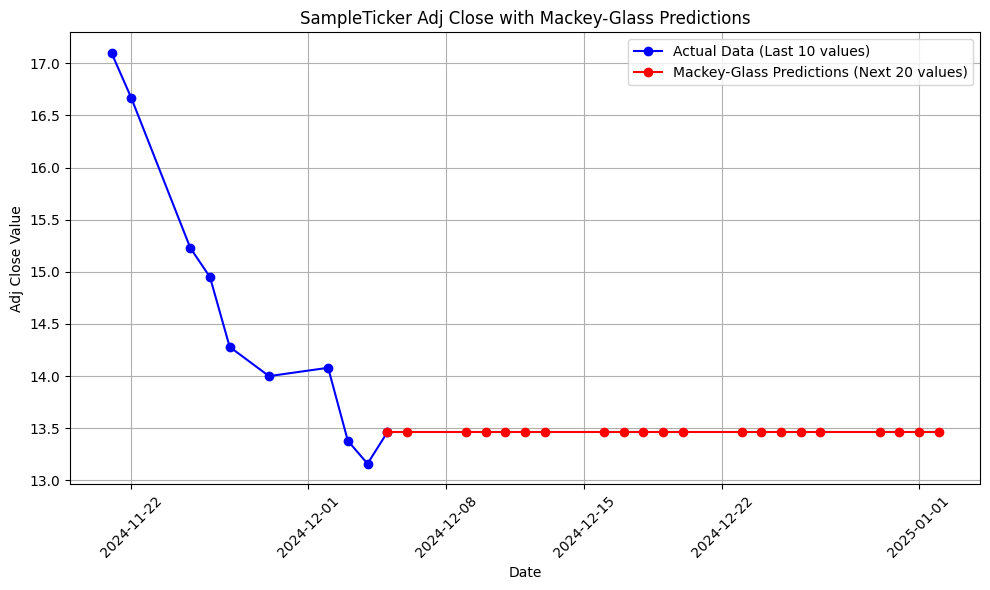

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

print(df)

# Mackey-Glass equation parameters
a = 2
b = 1
n = 10
tau = 17  # Delay

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Mackey-Glass equation
num_predictions = 20
time = np.linspace(0, 200, 1000)  # Time range for integration

# Extend initial history for the Mackey-Glass equation
history_length = tau + len(last_10_values)
initial_history = np.zeros(history_length)  # Initialize with zeros
initial_history[-len(last_10_values):] = last_10_values  # Fill with last known values

# Define the Mackey-Glass function
def mackey_glass(t, x):
    if t < tau:
        return [0]  # No feedback until t >= tau
    else:
        idx = int(t)  # Convert time to integer index
        if idx - tau >= 0 and idx < len(initial_history):
            return [(a * initial_history[idx - tau]) / (1 + initial_history[idx - tau] ** n) - b * x[0]]
        else:
            return [0]  # Return zero if out of bounds

# Use solve_ivp to integrate the Mackey-Glass equation
sol = solve_ivp(mackey_glass, [0, 200], [initial_value], t_eval=time)

# Get the predicted values
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Mackey-Glass Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Mackey-Glass Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# MF-DMA Multifractal Detrended Moving Average

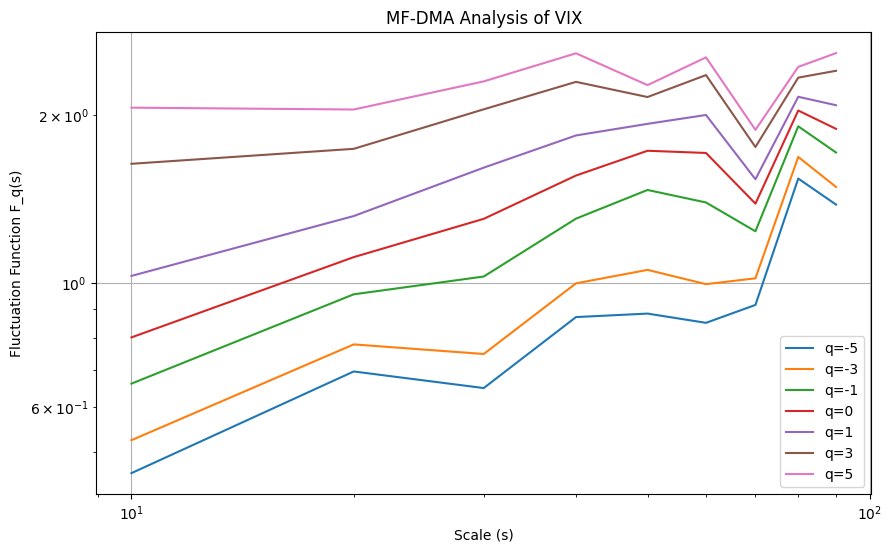

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_mf_dma(time_series, scale_range, q_values):
    """
    Perform MF-DMA analysis on a time series.

    :param time_series: Input time series as a NumPy array.
    :param scale_range: List of scales (segment sizes) to analyze.
    :param q_values: List of q values for multifractal analysis.
    :return: Dictionary containing fluctuation functions for each q.
    """
    N = len(time_series)
    fluctuation_functions = {q: [] for q in q_values}

    for scale in scale_range:
        segments = int(N / scale)
        rms_list = []

        for i in range(segments):
            start = i * scale
            end = start + scale
            segment = time_series[start:end]
            trend = np.mean(segment)
            rms = np.sqrt(np.mean((segment - trend) ** 2))
            rms_list.append(rms)

        for q in q_values:
            if q == 0:
                fluctuation_functions[q].append(np.exp(0.5 * np.mean(np.log(np.array(rms_list) ** 2))))
            else:
                fluctuation_functions[q].append(np.mean(np.array(rms_list) ** q) ** (1 / q))

    return fluctuation_functions

# Load VIX data
# Copy data
df = data
vix_prices = df["Close"].values  # Adjust column name if needed

# Parameters
scale_range = range(10, 100, 10)  # Segment sizes
q_values = [-5, -3, -1, 0, 1, 3, 5]  # q values

# Perform MF-DMA
fluctuations = calculate_mf_dma(vix_prices, scale_range, q_values)

# Plot the fluctuation functions
plt.figure(figsize=(10, 6))
for q in q_values:
    plt.plot(scale_range, fluctuations[q], label=f"q={q}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Scale (s)")
plt.ylabel("Fluctuation Function F_q(s)")
plt.title("MF-DMA Analysis of VIX")
plt.legend()
plt.grid(True)
plt.show()


# Pearson

**Pearson Correlation Coefficient**

In [ ]:
# Copy data
df = data

df[['Close', 'Volume']].corr()
corelation = df['Close'].corr(df['Volume'])
print(f"Pearson Correlation Coefficient: {corelation}")

def print_pearson_legend():
    print("### Pearson Correlation Interpretation ###\n")
    print("The Pearson Correlation Coefficient (r) ranges between -1 and +1 and describes the linear relationship between two variables.")
    print("\nInterpretation of the Pearson Coefficient:")
    print("  - **r = +1**: Perfect positive linear relationship (as one variable increases, the other increases).")
    print("  - **r = -1**: Perfect negative linear relationship (as one variable increases, the other decreases).")
    print("  - **r = 0**: No linear relationship between the variables.")
    print("\nRange Interpretation:")
    print("  - **0.7 ≤ |r| ≤ 1**: Strong linear relationship.")
    print("  - **0.3 ≤ |r| < 0.7**: Moderate linear relationship.")
    print("  - **0 ≤ |r| < 0.3**: Weak linear relationship.")
    print("\nNote: Pearson correlation only captures linear relationships. Nonlinear correlations may exist even if r is close to 0.\n")

# Example of calling the legend
print_pearson_legend()


Pearson Correlation Coefficient: nan
### Pearson Correlation Interpretation ###

The Pearson Correlation Coefficient (r) ranges between -1 and +1 and describes the linear relationship between two variables.

Interpretation of the Pearson Coefficient:
  - **r = +1**: Perfect positive linear relationship (as one variable increases, the other increases).
  - **r = -1**: Perfect negative linear relationship (as one variable increases, the other decreases).
  - **r = 0**: No linear relationship between the variables.

Range Interpretation:
  - **0.7 ≤ |r| ≤ 1**: Strong linear relationship.
  - **0.3 ≤ |r| < 0.7**: Moderate linear relationship.
  - **0 ≤ |r| < 0.3**: Weak linear relationship.

Note: Pearson correlation only captures linear relationships. Nonlinear correlations may exist even if r is close to 0.



/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Perlin Noise

In [20]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56275 sha256=89f209def33c57234963f2a12a0afb2a3249dd2c0d4dbc22171b734ee59fb7d0
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


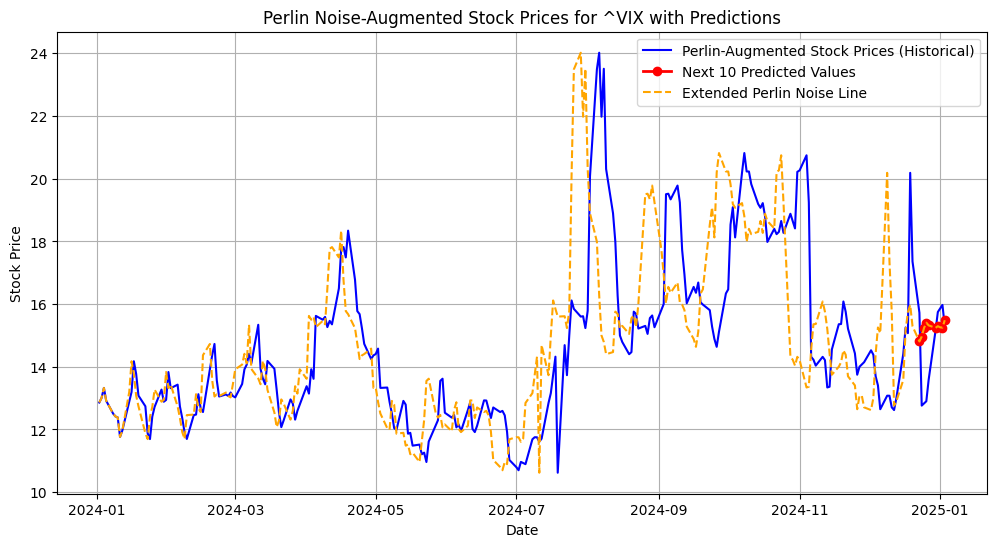

In [21]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from noise import pnoise1

# Generate Perlin noise
def generate_perlin_noise(length, scale=0.1, octaves=1, persistence=0.5, lacunarity=2.0, seed=None):
    """
    Generate a Perlin noise time series.
    Parameters:
    - length: Number of points in the time series.
    - scale: Controls the "zoom level" of the noise (smaller values give smoother noise).
    - octaves: Number of layers of Perlin noise combined.
    - persistence: Amplitude of each octave relative to the previous.
    - lacunarity: Frequency of each octave relative to the previous.
    - seed: Random seed for consistent results.
    Returns:
    - np.array of Perlin noise values.
    """
    if seed is not None:
        np.random.seed(seed)
    base = np.random.randint(0, 1000) if seed is None else seed  # Random or fixed base for Perlin
    noise = np.array([pnoise1(i * scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, base=base) for i in range(length)])
    return noise

# Fetch stock price data
df = data

# Use the closing prices
stock_prices = df['Close'].dropna().values
time_steps = len(stock_prices)

# Normalize stock prices for blending with Perlin noise
min_price, max_price = min(stock_prices), max(stock_prices)
normalized_prices = (stock_prices - min_price) / (max_price - min_price)

# Generate Perlin noise with the same length as the stock prices
perlin_noise = generate_perlin_noise(length=time_steps + 10, scale=0.05, octaves=4, persistence=0.6, lacunarity=2.0, seed=42)

# Blend Perlin noise with normalized stock prices for the historical series
blended_prices = normalized_prices + 0.2 * perlin_noise[:time_steps]  # Adjust noise amplitude
blended_prices = (blended_prices - np.min(blended_prices)) / (np.max(blended_prices) - np.min(blended_prices))  # Re-normalize
blended_prices = blended_prices * (max_price - min_price) + min_price  # Map back to original price range

# Generate the next 10 noise-augmented stock price predictions
next_10_values = perlin_noise[time_steps:] * (max_price - min_price) * 0.2 + blended_prices[-1]

# Combine the historical and predicted values
extended_perlin_line = np.concatenate([blended_prices, next_10_values])

# Generate extended dates
extended_dates = pd.date_range(df.index[0], periods=time_steps + 10, freq='B')

# Plot the combined Perlin noise line
plt.figure(figsize=(12, 6))
plt.plot(df.index, blended_prices, label="Perlin-Augmented Stock Prices (Historical)", color="blue")
plt.plot(extended_dates[-10:], next_10_values, 'ro-', label="Next 10 Predicted Values", linewidth=2)  # Red dots for predictions
plt.plot(extended_dates, extended_perlin_line, color="orange", linestyle="dashed", label="Extended Perlin Noise Line")

# Enhance the graph
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Perlin Noise-Augmented Stock Prices for {ticker} with Predictions")
plt.legend()
plt.grid(True)
plt.show()


# Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Copy data
df = data

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'

# Prepare data
X = np.arange(len(df)).reshape(-1, 1)  # Feature matrix (time steps)
y = df['Volume']  # Target variable (volume)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

# Predict the next 10 values beyond the current data range
future_steps = 10
X_future = np.arange(len(df), len(df) + future_steps).reshape(-1, 1)
future_predictions = model.predict(X_future)

# Plot the results
plt.plot(df.index, df['Volume'], label='Actual Volumes')
plt.plot(df.index[-len(y_test):], predictions, label='Random Forest Predictions on Test Set')
plt.plot(df.index[-1:].append(pd.RangeIndex(start=len(df), stop=len(df) + future_steps)),
         np.concatenate([df['Volume'].values[-1:], future_predictions]),
         label='Next 10 Volume Predictions', linestyle='--', color='red')
plt.legend()
plt.title('Random Forest for Volumes with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


NameError: name 'data' is not defined

# Rössler Attractor - Chaotic Algorithm

Need to revise

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Rössler attractor parameters
a = 0.2
b = 0.2
c = 5.7

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Rössler attractor
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Rössler attractor equations
def rossler(t, state):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# Use solve_ivp to integrate the Rössler attractor equations
initial_state = [initial_value, 0.0, 0.0]  # Assuming y and z start at 0
sol = solve_ivp(rossler, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Rössler Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Rössler Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Date'

# Standard Map (Chirikov-Taylor Map) - Chaotic Algorithm

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data

# Standard Map parameters
K = 1.0  # Nonlinearity parameter

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Standard Map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Standard Map
for _ in range(num_predictions - 1):
    # Calculate the next values
    x_next = x + K * np.sin(y)
    y_next = y + x_next

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Standard Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Standard Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Date'

#  Quantum Neural Network for Time Series Prediction

Not working


In [ ]:
!pip install pennylane pennylane-qiskit torch numpy matplotlib

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 710.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set up the quantum device
n_qubits = 4  # Number of qubits to use in the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum layer definition
def quantum_layer(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QNN model
class QNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        # Initialize random quantum weights
        self.q_weights = torch.nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        # Classical layers
        self.fc1 = nn.Linear(n_qubits, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        q_out = []
        # Use quantum circuit for each input data point
        for xi in x:
            q_out.append(qml.execute([quantum_layer], dev, [xi.numpy(), self.q_weights])[0])
        q_out = torch.tensor(q_out)
        # Apply classical neural network layers
        x = torch.relu(self.fc1(q_out))
        return self.fc2(x)

# Generate a toy time series data
np.random.seed(0)
n_points = 100
time_series = np.sin(np.linspace(0, 10 * np.pi, n_points)) + 0.1 * np.random.randn(n_points)

# Prepare the data for training
window_size = 10
X = []
y = []
for i in range(len(time_series) - window_size):
    X.append(time_series[i:i + window_size])
    y.append(time_series[i + window_size])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Initialize the QNN model
qnn_model = QNN(n_qubits, n_layers=3)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(qnn_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train the QNN model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = qnn_model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Forecast the next 10 values
with torch.no_grad():
    future_X = X[-1].unsqueeze(0)  # Take the last known window
    future_preds = []
    for _ in range(10):
        future_y = qnn_model(future_X)
        future_preds.append(future_y.item())
        # Slide the window
        future_X = torch.cat([future_X[:, 1:], future_y.unsqueeze(1)], dim=1)

# Plot the results
plt.plot(range(len(time_series)), time_series, label='Actual Data')
plt.plot(range(len(time_series), len(time_series) + 10), future_preds, label='Predicted Data')
plt.legend()
plt.show()

TypeError: len() of unsized object

# VIX Tests

**VIX Tests - VIX Days between spikes**

[*********************100%***********************]  1 of 1 completed


Date
2000-11-14    1.0
2000-11-15    1.0
2000-11-16    1.0
2000-11-17    1.0
2000-11-20    3.0
             ... 
2024-12-20    1.0
2024-12-23    3.0
2024-12-24    1.0
2024-12-26    2.0
2024-12-27    1.0
Name: Date, Length: 6067, dtype: float64
Average number of days between significant VIX spikes: 1.45


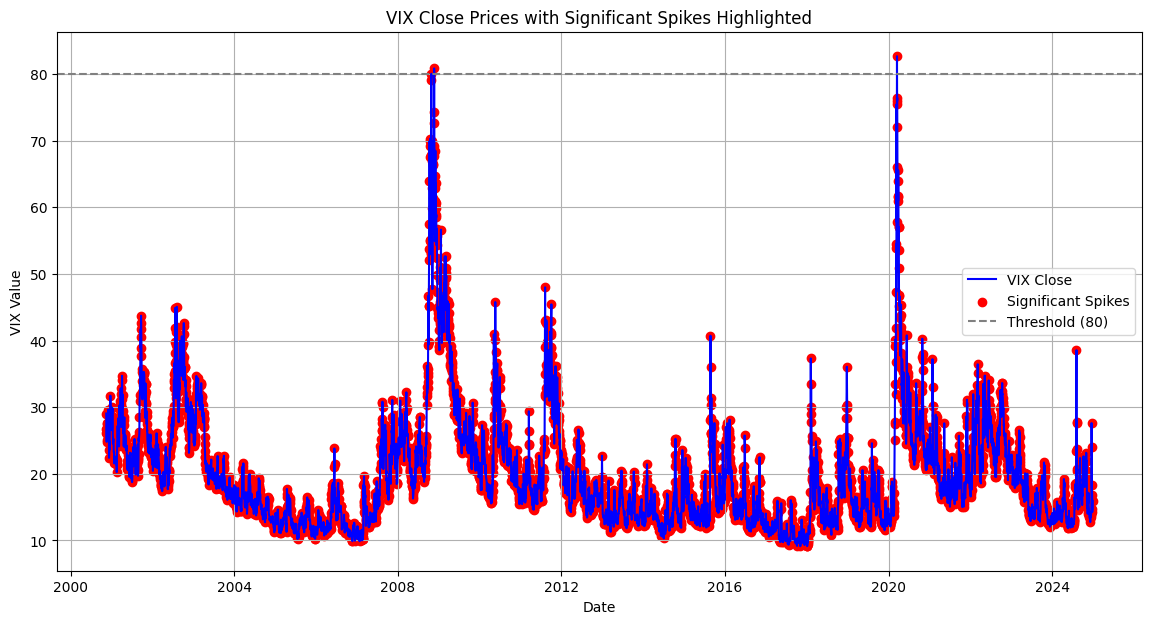

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

end = datetime.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2000-11-13', end=end)

# Define the threshold for significant spikes
threshold = 80

# Identify dates where VIX exceeds the threshold
spike_dates = vix_data[vix_data['Close'] > threshold].index

# Calculate the number of days between consecutive spikes
days_between_spikes = spike_dates.to_series().diff().dt.days.dropna()

print(days_between_spikes)

# Calculate the average number of days between spikes
average_days_between_spikes = days_between_spikes.mean()
print(f'Average number of days between significant VIX spikes: {average_days_between_spikes:.2f}')

plt.figure(figsize=(14, 7))
plt.plot(vix_data.index, vix_data['Close'], label='VIX Close', color='blue')
plt.scatter(spike_dates, vix_data.loc[spike_dates]['Close'], color='red', label='Significant Spikes')
plt.axhline(y=threshold, color='gray', linestyle='--', label=f'Threshold ({threshold})')
plt.title('VIX Close Prices with Significant Spikes Highlighted')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-24-179d5443dd3f>:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_value = float(row['Close'])


Average number of days between significant VIX spikes: 34.93
Predicted next spike date relative to today: 2025-01-26


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


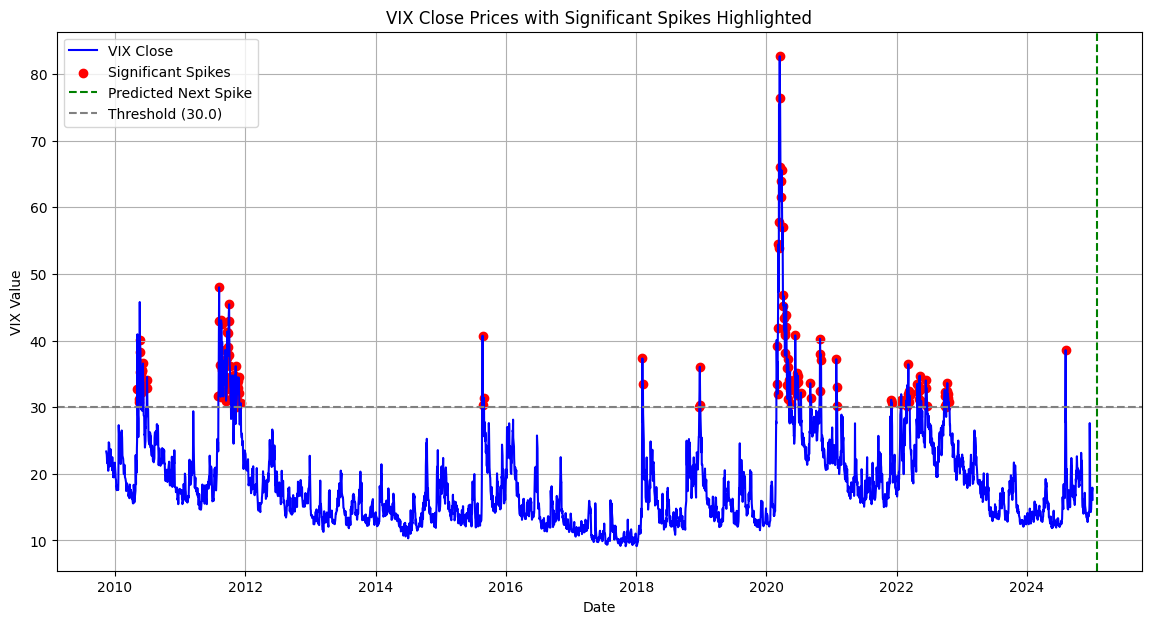

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from datetime import datetime

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2009-11-13', end=end_time)

# Define the threshold for significant spikes
threshold = 30.0

# Initialize list to collect spike dates
spike_dates = []

# Identify dates where VIX exceeds the threshold
for index, row in vix_data.iterrows():
    try:
        # Convert 'Close' value to float explicitly
        close_value = float(row['Close'])
        if close_value > threshold:
            # Append the date if 'Close' exceeds the threshold
            spike_dates.append(index)
    except (ValueError, TypeError) as e:
        print(f"Skipping row at index {index} due to conversion error: {e}")

# Remove consecutive spike dates (keep only the first in each streak)
unique_spike_dates = [spike_dates[0]] if spike_dates else []
for i in range(1, len(spike_dates)):
    if (spike_dates[i] - unique_spike_dates[-1]).days > 1:
        unique_spike_dates.append(spike_dates[i])

# Calculate days between consecutive unique spikes
days_between_spikes = [
    (unique_spike_dates[i] - unique_spike_dates[i - 1]).days
    for i in range(1, len(unique_spike_dates))
]

# Calculate average days between spikes
if days_between_spikes:
    average_days_between_spikes = sum(days_between_spikes) / len(days_between_spikes)
    print(f'Average number of days between significant VIX spikes: {average_days_between_spikes:.2f}')

    # Predict the next spike date relative to today
    today = pd.Timestamp(datetime.now()).tz_localize(None)
    last_spike_date = unique_spike_dates[-1].tz_localize(None)

    # Calculate the number of days since the last spike
    days_since_last_spike = (today - last_spike_date).days

    # Determine the next spike date
    if days_since_last_spike < average_days_between_spikes:
        # If we are still within the average interval, add the remaining days
        projected_days = average_days_between_spikes - days_since_last_spike
        next_spike_date = today + pd.Timedelta(days=projected_days)
    else:
        # If we've passed the interval, project the next spike based on multiples of the average
        cycles_passed = int(days_since_last_spike / average_days_between_spikes)
        next_spike_date = last_spike_date + pd.Timedelta(days=(cycles_passed + 1) * average_days_between_spikes)

    print(f'Predicted next spike date relative to today: {next_spike_date.date()}')
else:
    print(f"No significant spikes found for threshold {threshold}.")
    next_spike_date = None


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(vix_data.index, vix_data['Close'], label='VIX Close', color='blue')

# Highlight the unique spike dates
if unique_spike_dates:
    plt.scatter(unique_spike_dates, [vix_data.loc[date]['Close'] for date in unique_spike_dates], color='red', label='Significant Spikes')

# Add predicted next spike date to the plot
if next_spike_date:
    plt.axvline(x=next_spike_date, color='green', linestyle='--', label='Predicted Next Spike')

plt.axhline(y=threshold, color='gray', linestyle='--', label=f'Threshold ({threshold})')
plt.title('VIX Close Prices with Significant Spikes Highlighted')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.grid(True)
plt.show()


**VIX Tests - VIX Time Series with Highlighted Trend Changes**

[*********************100%***********************]  1 of 1 completed


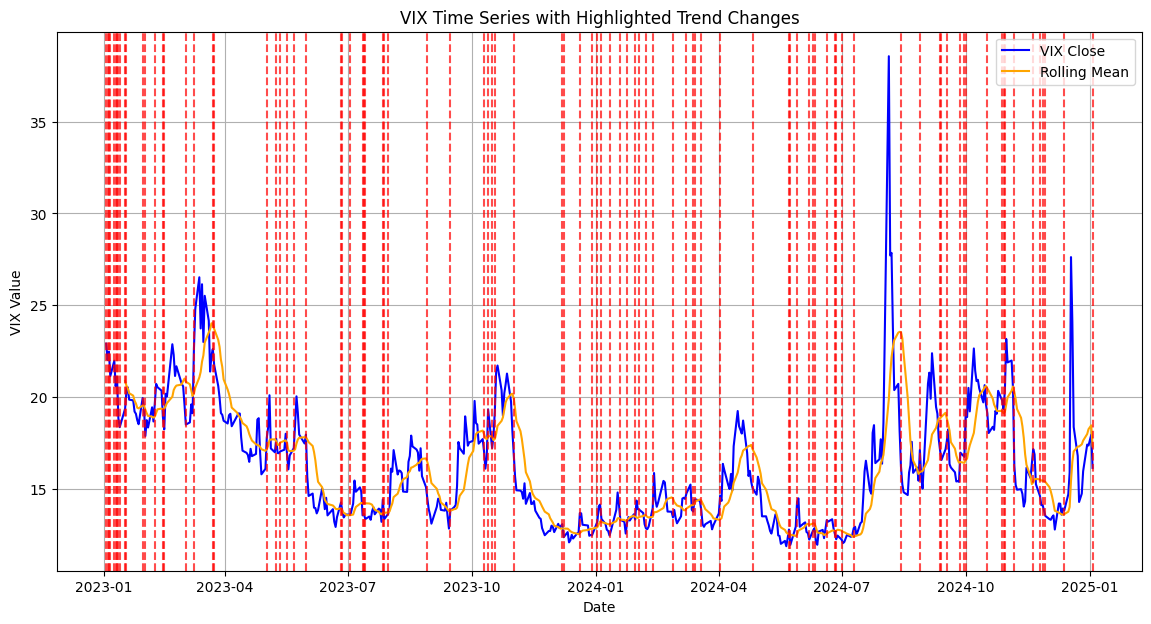

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)

# Reset index to bring 'Date' as a column
vix_data = vix_data.reset_index()

# Now set 'Date' as the index
vix_data.set_index('Date', inplace=True)

# Step 2: Calculate rolling mean and detect trend changes
window_size = 10  # Adjust the window size as needed
vix_data['Rolling_Mean'] = vix_data['Close'].rolling(window=window_size).mean()
vix_data['Trend_Change'] = vix_data['Rolling_Mean'].diff().apply(np.sign).diff()

# Identify the dates where trend changes occur
trend_change_dates = vix_data[vix_data['Trend_Change'] != 0].index

# Step 3: Plot the VIX time series and highlight trend changes
plt.figure(figsize=(14, 7))
plt.plot(vix_data.index, vix_data['Close'], label='VIX Close', color='blue')
plt.plot(vix_data.index, vix_data['Rolling_Mean'], label='Rolling Mean', color='orange')

# Highlight trend change points
for change_date in trend_change_dates:
    plt.axvline(x=change_date, color='red', linestyle='--', alpha=0.7)

plt.title('VIX Time Series with Highlighted Trend Changes')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.grid(True)
plt.show()


**VIX Tests - Monte Carlo Shuffled Projection for VIX**

[*********************100%***********************]  1 of 1 completed


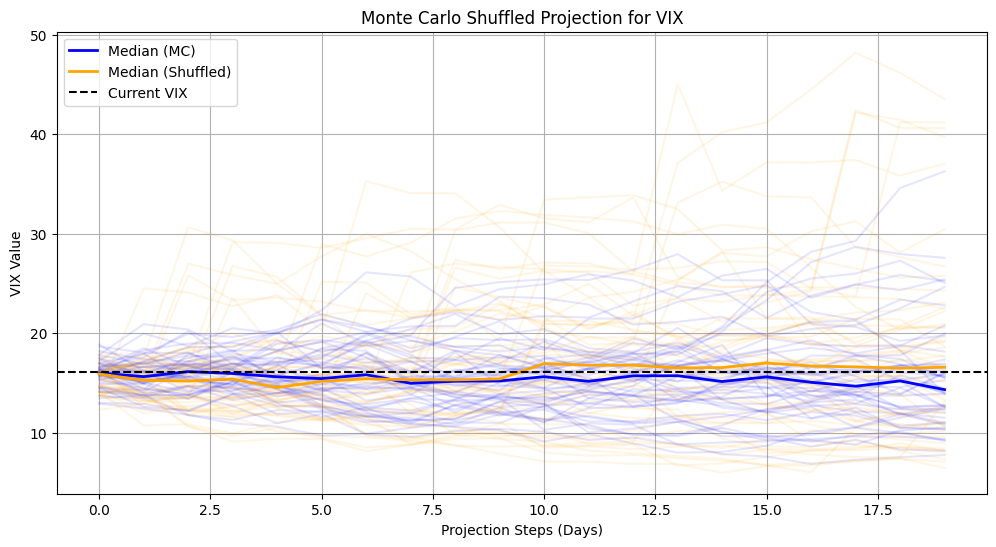

In [20]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)

# Check if data is valid
if vix_data.empty:
    raise ValueError("No data available for the specified time range.")

# Extract 'Adj Close' and flatten to a 1D array
vix_close = vix_data['Adj Close'].dropna().values.flatten()

# Debugging outputs
# print("VIX Close Data (Flattened):")
# print(vix_close)
# print("Shape of VIX Close Data:", vix_close.shape)

# Compute daily returns
vix_returns = np.diff(vix_close) / vix_close[:-1]

# Debugging outputs
# print("VIX Returns:")
# print(vix_returns)
# print("Shape of VIX Returns:", vix_returns.shape)

# Ensure mean and standard deviation are computed on valid data
if len(vix_returns) == 0:
    raise ValueError("Insufficient data to compute returns.")

# Mean and standard deviation of returns
mu = np.mean(vix_returns)
sigma = np.std(vix_returns)

# Monte Carlo parameters
n_simulations = 50  # Number of Monte Carlo simulations
n_steps = 20  # Number of future steps to project
shuffled_window = 30  # Shuffling window for historical data

# Generate Monte Carlo simulations
mc_simulations = np.zeros((n_steps, n_simulations))
for sim in range(n_simulations):
    vix_start = vix_close[-1]
    random_returns = np.random.normal(mu, sigma, n_steps)
    vix_path = [vix_start]
    for r in random_returns:
        next_value = vix_path[-1] * (1 + r)
        vix_path.append(next_value)
    mc_simulations[:, sim] = vix_path[1:]

# Shuffle historical returns for sensitivity analysis
shuffled_projections = np.zeros((n_steps, n_simulations))
for sim in range(n_simulations):
    shuffled_returns = np.random.choice(vix_returns[-shuffled_window:], n_steps, replace=True)
    vix_start = vix_close[-1]
    vix_path = [vix_start]
    for r in shuffled_returns:
        next_value = vix_path[-1] * (1 + r)
        vix_path.append(next_value)
    shuffled_projections[:, sim] = vix_path[1:]

# Compute percentiles for visualization
percentiles = [5, 25, 50, 75, 95]
mc_percentiles = np.percentile(mc_simulations, percentiles, axis=1)
shuffled_percentiles = np.percentile(shuffled_projections, percentiles, axis=1)

# Plot results
plt.figure(figsize=(12, 6))
for sim in range(50):
    plt.plot(mc_simulations[:, sim], color="blue", alpha=0.1)
    plt.plot(shuffled_projections[:, sim], color="orange", alpha=0.1)
plt.plot(mc_percentiles[2], label="Median (MC)", color="blue", linewidth=2)
plt.plot(shuffled_percentiles[2], label="Median (Shuffled)", color="orange", linewidth=2)
plt.axhline(y=vix_close[-1], color="black", linestyle="--", label="Current VIX")
plt.title("Monte Carlo Shuffled Projection for VIX")
plt.xlabel("Projection Steps (Days)")
plt.ylabel("VIX Value")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd  # Add this import
import matplotlib.pyplot as plt
import datetime as dt

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna().values.flatten()  # Ensure 1D shape

# Monte Carlo Simulation: Generate perturbations
num_simulations = 5
np.random.seed(42)

# Compute historical mean and standard deviation of returns
vix_returns = np.diff(vix_close) / vix_close[:-1]
mean_return = np.mean(vix_returns)
std_return = np.std(vix_returns)

# Generate Monte Carlo simulations for future predictions
future_steps = 50
future_predictions = []

for _ in range(num_simulations):
    # Start with the last VIX value
    future_simulation = [vix_close[-1]]
    for _ in range(future_steps):
        # Simulate the next step using the historical mean and std deviation
        next_step = future_simulation[-1] * (1 + np.random.normal(mean_return, std_return))
        future_simulation.append(next_step)
    future_predictions.append(future_simulation)

# Create a time index for future predictions
future_dates = pd.date_range(start=vix_data.index[-1], periods=future_steps + 1, freq='B')

# Plot the historical data
plt.figure(figsize=(14, 8))
time_index = vix_data.index
plt.plot(time_index, vix_close, label="Original VIX", color="blue", linewidth=2)

# Plot Monte Carlo future predictions
for prediction in future_predictions:
    plt.plot(future_dates, prediction, color="grey", alpha=0.3, linewidth=0.8)

# Highlight the mean prediction
mean_prediction = np.mean(future_predictions, axis=0)
plt.plot(future_dates, mean_prediction, color="orange", label="Mean Prediction", linewidth=2)

# Add labels and legend
plt.title("Monte Carlo Prediction of VIX (Next 50 Days)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("VIX Value", fontsize=14)
plt.legend(["Original VIX", "Monte Carlo Simulations", "Mean Prediction"], fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^VIX: No data found for this date range, symbol may be delisted


IndexError: index -1 is out of bounds for axis 0 with size 0

**VIX Tests - MCMC Projections for VIX**

In [10]:
!pip install numpyro
import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import datetime as dt

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna()

# Define the MCMC model
def model(data):
    trend = numpyro.sample("trend", dist.Normal(0, 1))  # Overall trend
    noise = numpyro.sample("noise", dist.HalfNormal(1))  # Noise scale
    for t in range(len(data)):
        predicted_value = (
            trend * t + numpyro.sample(f"state_{t}", dist.Normal(data[t - 1] if t > 0 else 0, noise))
        )
        numpyro.sample(f"obs_{t}", dist.Normal(predicted_value, noise), obs=data[t])

# Run the MCMC sampler
rng_key = random.PRNGKey(0)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=500)
mcmc.run(rng_key, data=jnp.array(vix_data))
posterior_samples = mcmc.get_samples()

# Extract samples for the trend and noise
trend_samples = posterior_samples["trend"]
noise_samples = posterior_samples["noise"]

# Project future values based on the inferred trend and noise
future_steps = 50
future_projections = []
for i in range(100):
    future_data = []
    prev_value = data[-1]
    for t in range(future_steps):
        new_value = prev_value + np.random.normal(trend_samples.mean(), noise_samples.mean())
        future_data.append(new_value)
        prev_value = new_value
    future_projections.append(future_data)

# Plot the historical data and projections
plt.figure(figsize=(14, 8))
plt.plot(range(len(data)), data, label="Historical Data", color="blue", linewidth=2)
for proj in future_projections[:10]:  # Show only a subset of projections
    plt.plot(range(len(data), len(data) + future_steps), proj, alpha=0.3, color="orange")
plt.title("MCMC Projections for VIX")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend(["Historical Data", "Projections"])
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^VIX: No data found for this date range, symbol may be delisted


sample: 100%|██████████| 1500/1500 [00:02<00:00, 618.11it/s, 7 steps of size 5.65e-01. acc. prob=0.92] 


KeyError: -1

**VIX Tests - Perturbation Analysis and Future Projections for VIX**

[*********************100%***********************]  1 of 1 completed


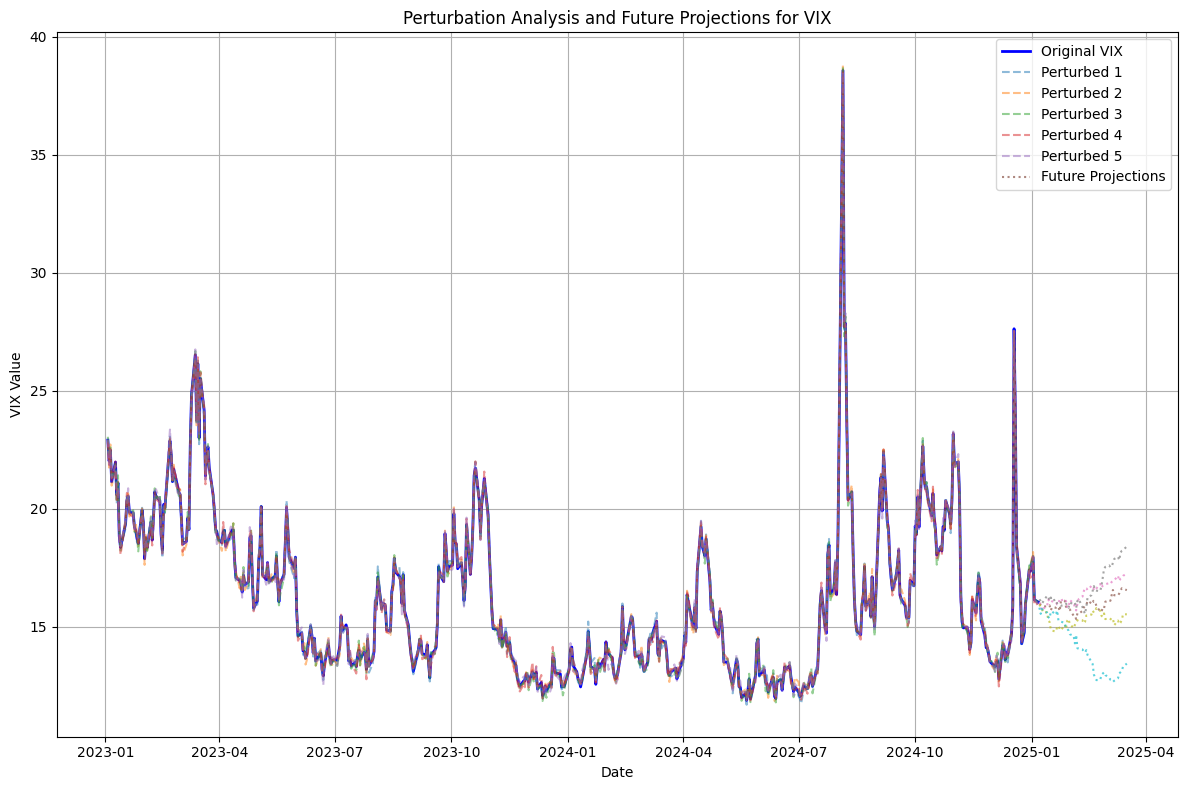

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import yfinance as yf
import datetime as dt

end_time = dt.date.today().strftime("%Y-%m-%d")

# Fetch VIX data from Yahoo Finance
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna()

# Step 2: Generate Perturbations
num_simulations = 50
#Extract the numpy array from the pandas series
vix_close_array = vix_close.values
#Flatten here to remove the second dimension
vix_close_array = vix_close_array.flatten()

perturbed_data = [
    vix_close_array + np.random.normal(0, 0.05 * vix_close.std(), len(vix_close_array))
    for _ in range(num_simulations)
]

# Step 3: Project Future Values
future_steps = 50
future_trends = [
    vix_close_array[-1] + np.cumsum(np.random.normal(0, 0.05 * vix_close.std(), future_steps))
    for _ in range(num_simulations)
]

# Pad original data with NaN values to match length of future trends
extended_vix_close = np.concatenate([vix_close_array, np.full(future_steps, np.nan)])


# Extend future projections to the same length as the original data (with NaNs)
extended_future_trends = [
    np.concatenate([np.full(len(vix_close_array), np.nan), trend]) for trend in future_trends
]

# Pad the perturbed data to have the same length
extended_perturbed_data = [
    np.concatenate([perturbed, np.full(future_steps, np.nan)]) for perturbed in perturbed_data
]

# Combine original and future projections
all_data = np.vstack([extended_vix_close] + extended_perturbed_data + extended_future_trends)

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(all_data.T).T


# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(imputed_data)

# Separate original data, perturbed data, and projections
original_proj = reduced_data[0]
perturbed_proj = reduced_data[1:num_simulations+1]
future_proj = reduced_data[num_simulations+1:]

plt.figure(figsize=(12, 8))

# Historical VIX data
plt.plot(vix_close.index, vix_close, label="Original VIX", color="blue", linewidth=2)

# Perturbed data
for perturbed in extended_perturbed_data[:5]:  # Show a subset of perturbed data
    plt.plot(vix_close.index, perturbed[:len(vix_close)], linestyle="dashed", alpha=0.5)

# Future projections
future_dates = pd.date_range(start=vix_close.index[-1], periods=future_steps + 1, freq="B")[1:]
for future in future_trends[:5]:  # Show a subset of future projections
    plt.plot(future_dates, future, linestyle="dotted", alpha=0.7)

plt.title("Perturbation Analysis and Future Projections for VIX")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.legend(["Original VIX"] + [f"Perturbed {i+1}" for i in range(5)] + ["Future Projections"])
plt.grid(True)
plt.tight_layout()
plt.show()


**VIX Tests - Synthetic Control Method for VIX**

In [11]:
!pip install --upgrade numpy scikit-learn



[*********************100%***********************]  1 of 1 completed


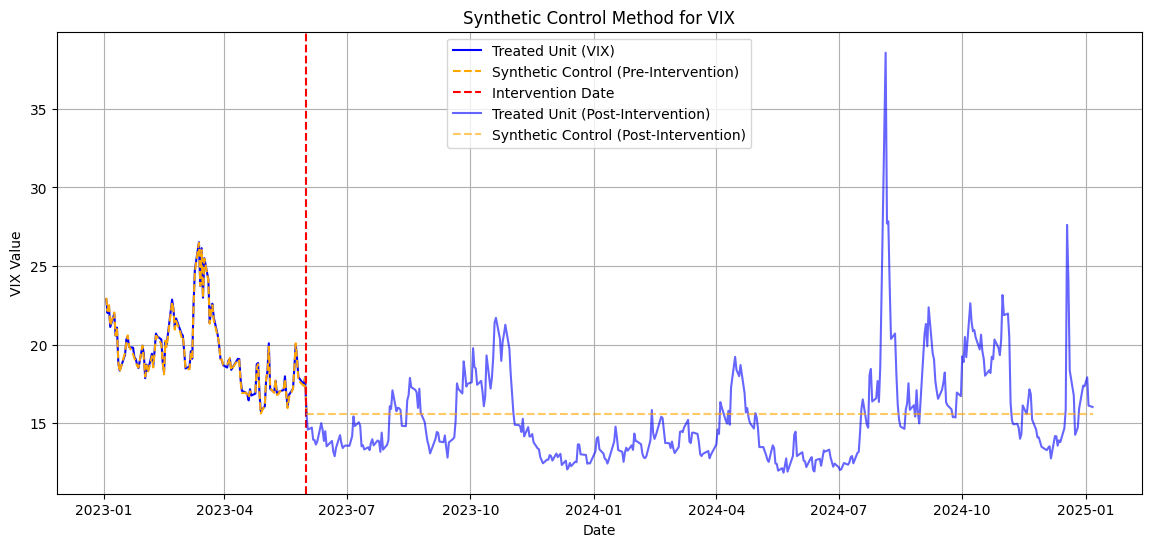

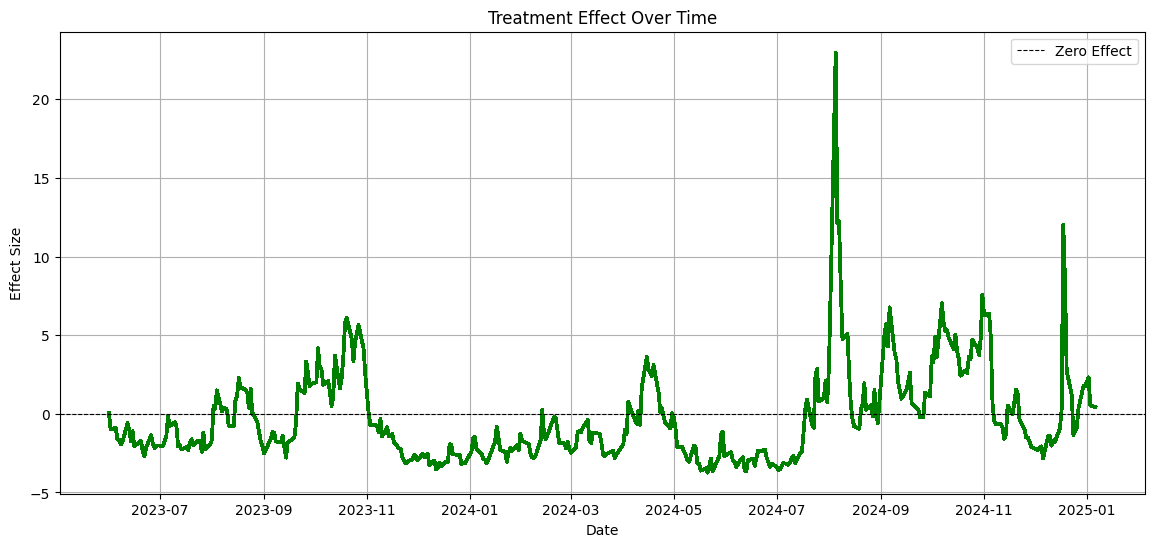

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import datetime as dt

# Fetch VIX data from Yahoo Finance
end_time = dt.date.today().strftime("%Y-%m-%d")
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna()

# Define a hypothetical intervention date
intervention_date = "2023-06-01"
pre_intervention = vix_close[:intervention_date]
post_intervention = vix_close[intervention_date:]

# Convert pre_intervention to NumPy array
pre_intervention_array = pre_intervention.values

# Generate synthetic control group
np.random.seed(42)
control_data_list = []
for i in range(5):  # Generate 5 synthetic controls
    control_series = pre_intervention_array.flatten() + np.random.normal(  # Flatten to make it 1D
        0, pre_intervention_array.std() * 0.1, len(pre_intervention_array)
    )
    control_data_list.append(control_series)

control_data = pd.DataFrame(control_data_list).T #Transposing to make the 5 time series be the columns
control_data.index = pre_intervention.index # set the index to be the same as pre_intervention


# Combine treated and control data
treated_unit = pre_intervention_array
control_units = control_data.values

# Fit a Ridge regression model to find optimal weights
ridge = Ridge(alpha=1.0)
ridge.fit(control_units, treated_unit)
weights = ridge.coef_

# Compute the synthetic control
synthetic_control = control_units @ weights

# Extend synthetic control into the post-intervention period
synthetic_post = np.full(len(post_intervention), synthetic_control[-1])

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(pre_intervention.index, treated_unit, label="Treated Unit (VIX)", color="blue")
plt.plot(pre_intervention.index, synthetic_control, label="Synthetic Control (Pre-Intervention)", linestyle="dashed", color="orange")
plt.axvline(x=pd.to_datetime(intervention_date), color="red", linestyle="--", label="Intervention Date")
plt.plot(post_intervention.index, post_intervention.values, label="Treated Unit (Post-Intervention)", color="blue", alpha=0.6)
plt.plot(post_intervention.index, synthetic_post, label="Synthetic Control (Post-Intervention)", linestyle="dashed", color="orange", alpha=0.6)
plt.title("Synthetic Control Method for VIX")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.legend()
plt.grid(True)
plt.show()

# Calculate the treatment effect
treatment_effect = post_intervention.values - synthetic_post

# Treatment effect plot
plt.figure(figsize=(14, 6))
plt.plot(post_intervention.index, treatment_effect, color="green", linewidth=2)
# plt.plot(post_intervention.index, treatment_effect,label="Treatment Effect", color="green", linewidth=2)
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8, label="Zero Effect")
plt.title("Treatment Effect Over Time")
plt.xlabel("Date")
plt.ylabel("Effect Size")
plt.legend()
plt.grid(True)
plt.show()


**VIX Tests - Projections Using Latin Hypercube Sampling (LHS)**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyDOE2 import lhs  # For Latin Hypercube Sampling
import yfinance as yf
import datetime as dt

# Fetch VIX data from Yahoo Finance
end_time = dt.date.today().strftime("%Y-%m-%d")
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna().values  # Historical VIX data

# Define parameters for projections
future_steps = 50  # Number of future time steps
num_projections = 100  # Number of projection paths
mean_drift = 0.05  # Mean trend drift (adjust for VIX dynamics)
std_drift = 1.0  # Standard deviation of the drift

# Latin Hypercube Sampling (LHS)
lhs_samples = lhs(2, samples=num_projections)  # LHS for 2 variables: drift and noise
drift_samples = norm.ppf(lhs_samples[:, 0], loc=mean_drift, scale=std_drift)  # Sample drift
noise_samples = norm.ppf(lhs_samples[:, 1], loc=0, scale=std_drift)  # Sample noise

# Generate Projections
projections = []
for i in range(num_projections):
    future_data = [vix_close[-1]]  # Start from the last historical value
    for t in range(future_steps):
        new_value = future_data[-1] + drift_samples[i] + np.random.normal(0, noise_samples[i])
        new_value = max(0, new_value)  # Ensure VIX values are non-negative
        future_data.append(new_value)
    projections.append(future_data[1:])  # Skip the initial repeated value

# Create Future Dates
future_dates = np.arange(len(vix_close), len(vix_close) + future_steps)

# Plot Results
plt.figure(figsize=(14, 8))

# Plot Historical Data
plt.plot(vix_data.index, vix_close, label="Historical VIX Data", color="blue", linewidth=2)

# Plot Projections
for proj in projections[:10]:  # Show only a subset of projection paths
    plt.plot(future_dates, proj, alpha=0.3, color="orange")

# Add Title and Labels
plt.title("VIX Projections Using Latin Hypercube Sampling (LHS)")
plt.xlabel("Time Steps")
plt.ylabel("VIX Value")
plt.legend(["Historical VIX Data", "Projections"])
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^VIX: No data found for this date range, symbol may be delisted


IndexError: index -1 is out of bounds for axis 0 with size 0

**VIX Tests - VIX Projections Using Geometric Brownian Motion (GBM)**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# Fetch VIX data from Yahoo Finance
end_time = dt.date.today().strftime("%Y-%m-%d")
vix_data = yf.download('^VIX', start='2023-01-01', end=end_time)
vix_close = vix_data['Close'].dropna().values  # Historical VIX data

# Parameters for Geometric Brownian Motion
mu = np.mean(np.diff(np.log(vix_close)))  # Drift (mean of log returns)
sigma = np.std(np.diff(np.log(vix_close)))  # Volatility (std of log returns)
S0 = vix_close[-1]  # Last observed VIX value
future_steps = 50  # Number of future steps to project
num_projections = 100  # Number of projection paths

# Generate GBM Projections
projections = []
dt = 1  # Time step (daily)
for _ in range(num_projections):
    future_prices = [S0]
    for _ in range(future_steps):
        dS = mu * dt + sigma * np.random.normal(0, np.sqrt(dt))
        new_price = future_prices[-1] * np.exp(dS)
        future_prices.append(new_price)
    projections.append(future_prices[1:])

# Create Future Dates
future_dates = np.arange(len(vix_close), len(vix_close) + future_steps)

# Plot Historical Data and Projections
plt.figure(figsize=(14, 8))
plt.plot(vix_data.index, vix_close, label="Historical VIX Data", color="blue", linewidth=2)
for proj in projections[:10]:  # Show a subset of projection paths
    plt.plot(future_dates, proj, alpha=0.3, color="orange")

# Add Title and Labels
plt.title("VIX Projections Using Geometric Brownian Motion (GBM)")
plt.xlabel("Time Steps")
plt.ylabel("VIX Value")
plt.legend(["Historical VIX Data", "Projections"])
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^VIX: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0